# Imports


In [40]:
import os
import random
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
from PIL.ImageOps import invert


 # Parameter Dashboard


In [41]:
# Parameters
min_image_size = 800        # Minimum image size (pixels)
max_image_size = 1200       # Maximum image size (pixels)

min_component_size = 80     # Minimum component size (pixels)
max_component_size = 160    # Maximum component size (pixels)

uses_per_component = 2      # Number of times each component is used

val_ratio = 0.15            # Validation set ratio (0-1)

# Dataset generation
This roboflow code will download a dataset from roboflow universe

In [42]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="")
# project = rf.workspace("sarl").project("electronic-circuits-ifz6c")
# version = project.version(1)
# dataset = version.download("yolov5")

# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="")
# project = rf.workspace("development-tohnm").project("cghd-full-supplemented")
# version = project.version(14)
# dataset = version.download("yolov5")



In [46]:
def convert(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = box[0] / dw
    y = box[1] / dh
    w = box[2] / dw
    h = box[3] / dh
    x_min = int(x - w / 2)
    y_min = int(y - h / 2)
    x_max = int(x + w / 2)
    y_max = int(y + h / 2)
    return (x_min, y_min, x_max, y_max)

def convert_bmg(arr1):


    # convert to grayscale
    if isinstance(arr1, np.ndarray):
        arr1 = Image.fromarray(arr1.astype('uint8'), 'RGB')
    
    test_image = arr1.resize((25, 25))

    img = test_image.convert('L')

    # invert image
    img = invert(img)

    # increase contrast of image
    img = ImageEnhance.Contrast(img).enhance(2)

    # make all pixels below 200 black
    img = img.point(lambda p: p > 150 and 255)

    # smoothen image
    img = img.filter(ImageFilter.SMOOTH)
    # img.show()
   
    return np.array(img)


In [47]:
circuit_dataset = 'dataset/CGHD-full-supplemented-14'#'dataset/circuits'
circ_imgs = os.listdir(circuit_dataset)

max_junc=250
total_junctions = 0
img_lst = []

In [48]:
import yaml


# Load the YAML file
with open(circuit_dataset+'/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

image_path = 'dataset/'+data['train']  # Adjust for 'val' if necessary
label_path ='dataset/'+ data['train'][:-6]+'labels'
print(label_path)
junction_index = data['names'].index('junction')
junction_dir = circuit_dataset+'/junctions'
os.makedirs(junction_dir, exist_ok=True)
print(label_path)

padding = 2
# Process each label file
for label_file in os.listdir(label_path):
    if label_file.endswith('.txt'):
        with open(os.path.join(label_path, label_file), 'r') as file:
            lines = file.readlines()
        
        image_file = label_file.replace('.txt', '.jpg')  # Check your image extension
        
        image = cv2.imread(os.path.join(image_path, image_file))
        if image is not None:
            for idx, line in enumerate(lines):
                parts = line.strip().split()
                class_id = int(parts[0])
                if class_id == junction_index:
                    bbox = tuple(map(float, parts[1:]))
                    img_size = (image.shape[1], image.shape[0])  # width, height
                    
                        
                    abs_bbox = convert(img_size, bbox)
                    w = abs_bbox[3]-abs_bbox[1]
                    h = abs_bbox[2]-abs_bbox[0]
                    
                    if w>=10 and h>=10:
                        total_junctions+=1
                        cropped_image = image[abs_bbox[1]-padding:abs_bbox[3]+padding, abs_bbox[0]-padding:abs_bbox[2]+padding]
                        cropped_image = convert_bmg(cropped_image)
                        # Save cropped image
                        cropped_filename = f"{os.path.splitext(image_file)[0]}_junction_{idx}.jpg"
                        cv2.imwrite(os.path.join(junction_dir, cropped_filename), cropped_image)
                        print(f'Saved {cropped_filename} in {junction_dir}/')
                        loc = junction_dir+'/'+cropped_filename
                        img_lst.append(loc)
            if total_junctions>=max_junc:
                break

    if total_junctions>=max_junc:
                break


dataset/CGHD-full-supplemented-14/train/labels
dataset/CGHD-full-supplemented-14/train/labels
Saved -trashed-1662750475-IMG_20220810_190255_jpg.rf.faacee29984167b90e6ad4de6246f93e_junction_3.jpg in dataset/CGHD-full-supplemented-14/junctions/
Saved -trashed-1662750475-IMG_20220810_190255_jpg.rf.faacee29984167b90e6ad4de6246f93e_junction_4.jpg in dataset/CGHD-full-supplemented-14/junctions/
Saved -trashed-1662750475-IMG_20220810_190255_jpg.rf.faacee29984167b90e6ad4de6246f93e_junction_5.jpg in dataset/CGHD-full-supplemented-14/junctions/
Saved -trashed-1662750475-IMG_20220810_190255_jpg.rf.faacee29984167b90e6ad4de6246f93e_junction_6.jpg in dataset/CGHD-full-supplemented-14/junctions/
Saved -trashed-1662750475-IMG_20220810_190255_jpg.rf.faacee29984167b90e6ad4de6246f93e_junction_7.jpg in dataset/CGHD-full-supplemented-14/junctions/
Saved -trashed-1662750475-IMG_20220810_190255_jpg.rf.faacee29984167b90e6ad4de6246f93e_junction_8.jpg in dataset/CGHD-full-supplemented-14/junctions/
Saved -trash

In [49]:
# # junctions_folder = 'dataset\circuits\junctions'

# trial_img = r'dataset\circuits\junctions\C128_D1_P4_jpg.rf.fd2ecda8cdaa0121e6c87362a311d2e4_junction_12.jpg'
# trial_img = r'dataset\circuits\junctions\C120_D1_P2_jpg.rf.ce48b002ab75e4bfaf48c751be3436c8_junction_6.jpg'
# image = cv2.imread(trial_img)
# # find edges in image
# edges = cv2.Canny(image, 100, 200, apertureSize=3)
# # print(edges)
# # find lines in image
# print(len(edges))
# lines = cv2.HoughLinesP(edges, 1.5, np.pi / 180,10) #threshold=10, minLineLength=10, maxLineGap=8)

# print(len(lines))

# # draw lines on image
# for points in lines:
#     x1, y1, x2, y2 = points[0]
#     cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# # convert image back to PIL image
# image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# # show image
# image.show()

In [50]:
# img_list =  [r'dataset\circuits\junctions\C114_D2_P3_jpg.rf.f0d9b5c9c013c26bca15b59475943ac7_junction_6.jpg', r'dataset\circuits\junctions\C112_D1_P1_jpg.rf.dee444061e9398545998b66dd67cd052_junction_8.jpg', r'dataset\circuits\junctions\C128_D1_P4_jpg.rf.fd2ecda8cdaa0121e6c87362a311d2e4_junction_12.jpg', r'dataset\circuits\junctions\C128_D1_P3_jpg.rf.331bd24329d9dc82b7411c18d75d47da_junction_3.jpg']
# n = 4
# for i in range(len(img_list)):
#     img = np.array(cv2.imread(img_list[i]))
#     # Assuming 'img' is the image array and 'n' is the width/height of the strips you want
#     height, width, _ = img.shape
#     print(width//4,3*width//4)
#     # Define the center regions for each edge:
#     top_edge_strip = img[:n, width//4:3*width//4]      # Top center strip
#     bottom_edge_strip = img[height-n:, width//4:3*width//4]  # Bottom center strip
#     left_edge_strip = img[height//4:3*height//4, :n]   # Left center strip
#     right_edge_strip = img[height//4:3*height//4, width-n:]  # Right center strip

#     region1, region2, region3, region4 = top_edge_strip, bottom_edge_strip, left_edge_strip, right_edge_strip


#     print(region1.sum(), region2.sum(), region3.sum(), region4.sum())
#     print(region1.shape, region2.shape, region3.shape, region4.shape)
#     a,b,c = region1.shape
#     total_count = a*b*c
#     # Print the sum of each region
#     print(f"Sums of regions for {img_list[i]}:")
#     print("Top sum:", region1.sum(), "Percentage:", region1.sum()/total_count)
#     print("Bottom  sum:", region2.sum(), "Percentage:", region2.sum()/total_count)
#     print("Left sum:", region3.sum(), "Percentage:", region3.sum()/total_count)
#     print("Right 4 sum:", region4.sum(), "Percentage:", region4.sum()/total_count)

    
#     # Display the image
#     display(PILImage.fromarray(img))




#     # section = np.array(img_list[i])[8:17,0:8]
#     # print(np.sum(section))
#     # img_sec = Image.fromarray(section)
#     # img_sec.show()
    


In [51]:
from IPython.display import display, Image
from PIL import Image as PILImage

In [53]:
df_labels = dict()
results = []
folder = 'dataset/electronic-component-classification/dataset/circuits/junctions'#'dataset/circuits/junctions/'
n =4
print(len(img_lst))
print(img_lst[0])

256
dataset/CGHD-full-supplemented-14/junctions/-trashed-1662750475-IMG_20220810_190255_jpg.rf.faacee29984167b90e6ad4de6246f93e_junction_3.jpg


In [54]:
for img_path in img_lst:
    
    img = cv2.imread(img_path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct processing
    height, width, _ = img.shape
    
    # Extract strips
    top_edge_strip = img[:n, width//4:3*width//4]
    bottom_edge_strip = img[height-n:, width//4:3*width//4]
    left_edge_strip = img[height//4:3*height//4, :n]
    right_edge_strip = img[height//4:3*height//4, width-n:]

    # Calculate the encoding based on sum
    total_pixels = top_edge_strip.size + bottom_edge_strip.size + left_edge_strip.size + right_edge_strip.size
    encoding = [
        1 if top_edge_strip.sum() / total_pixels >= 6.9 else 0,
        1 if bottom_edge_strip.sum() / total_pixels >= 6.9 else 0,
        1 if left_edge_strip.sum() / total_pixels >= 6.9 else 0,
        1 if right_edge_strip.sum() / total_pixels >= 6.9 else 0
    ]

    # Append results
    results.append([img_path] + encoding)


In [55]:
# Create a DataFrame and save to CSV
df = pd.DataFrame(results, columns=['Image_Path', 'Top_Edge', 'Bottom_Edge', 'Left_Edge', 'Right_Edge'])
df.to_csv('image_edge_encodings.csv', index=False)


# Read and check which encodings in final dataset


In [56]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


In [57]:
df = pd.read_csv('image_edge_encodings.csv')
selected_images = []


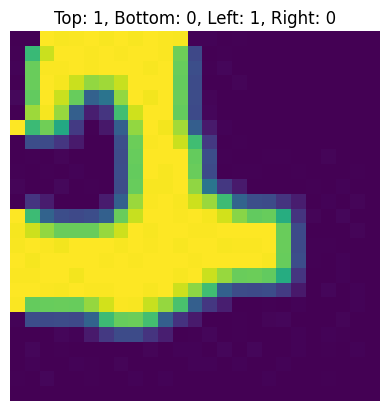

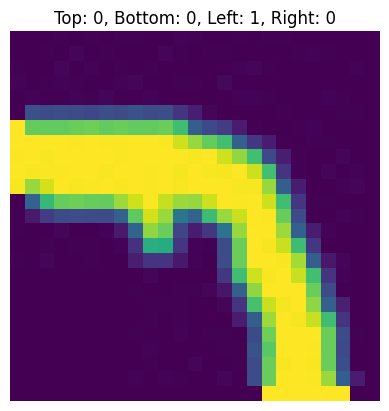

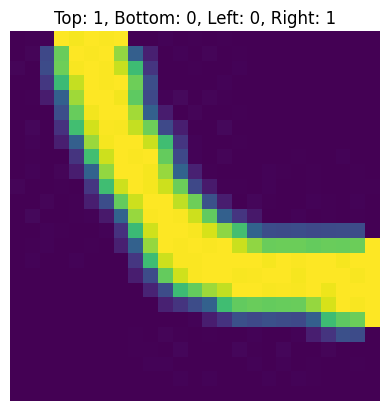

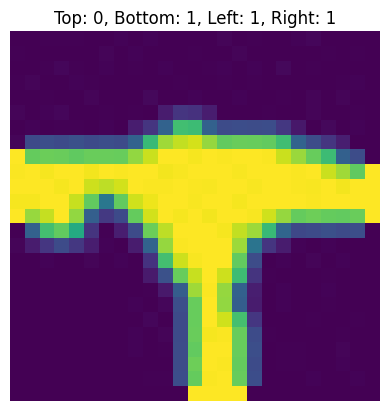

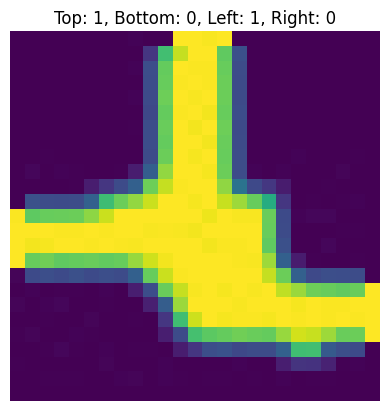

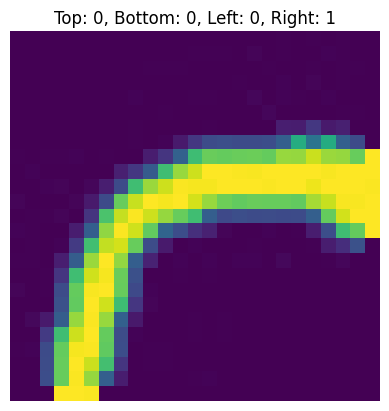

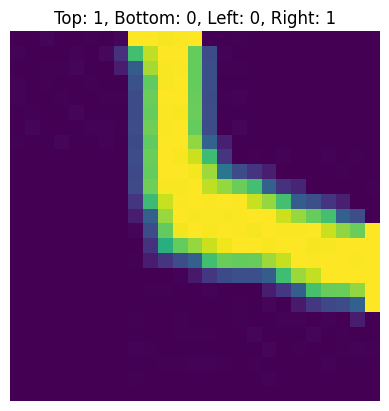

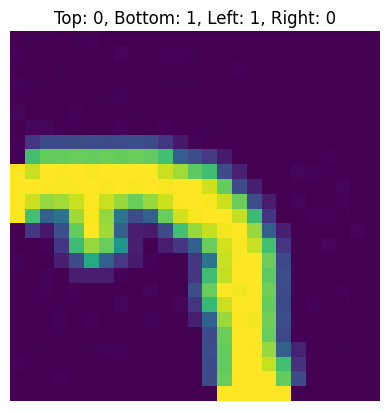

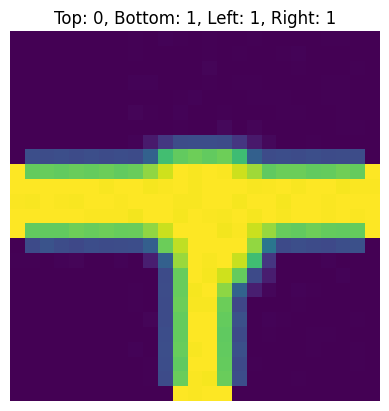

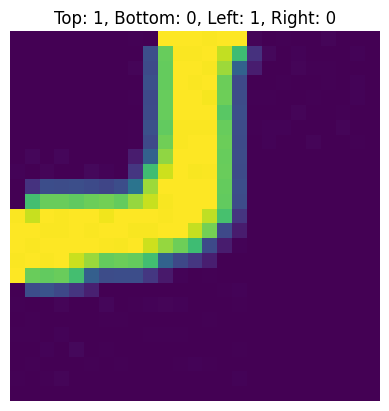

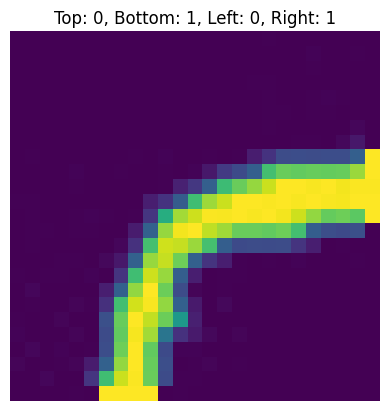

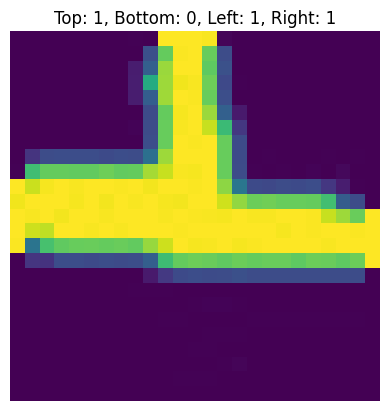

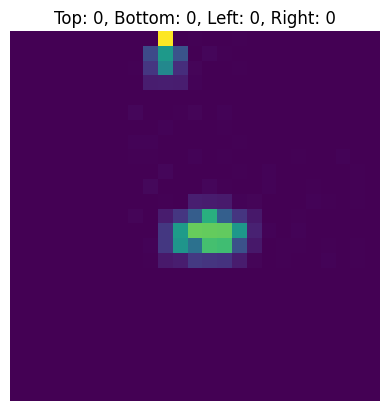

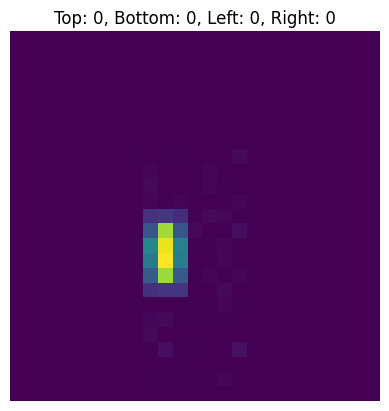

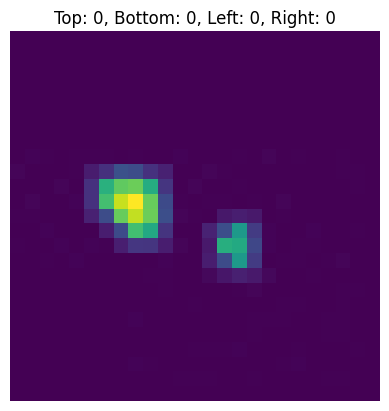

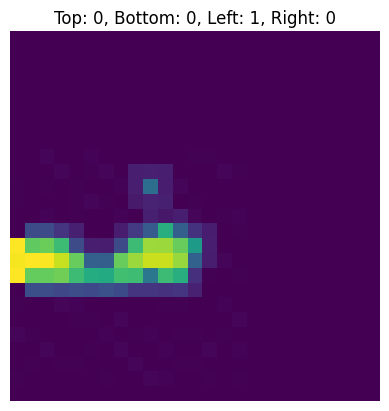

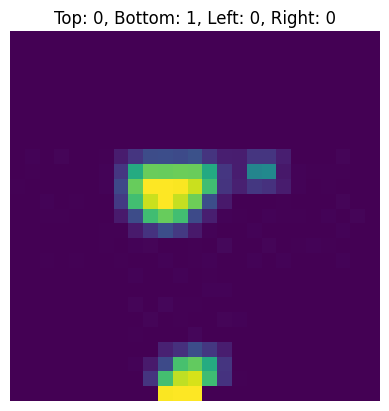

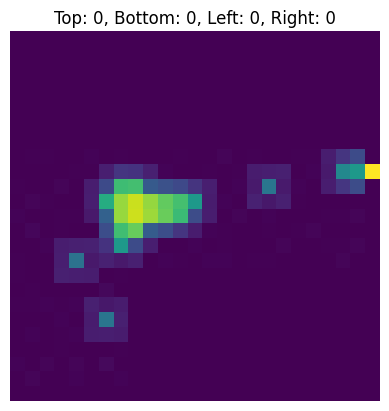

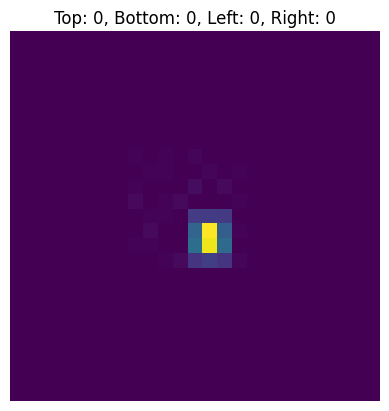

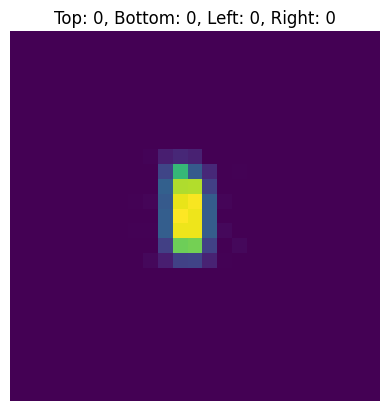

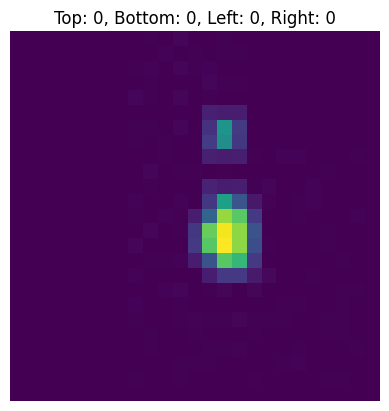

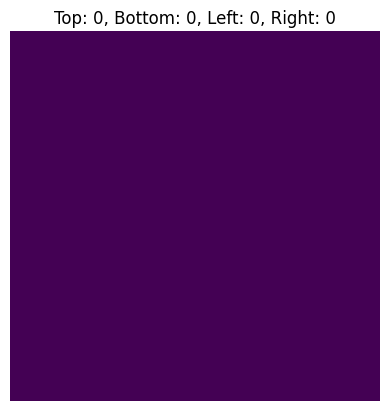

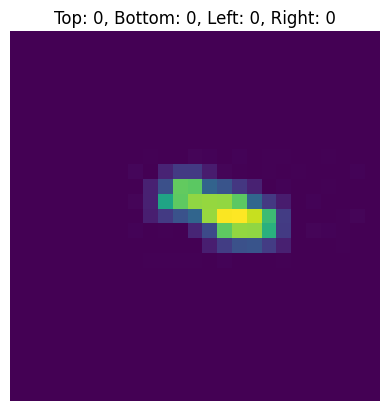

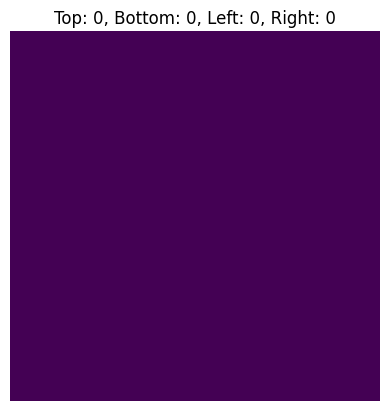

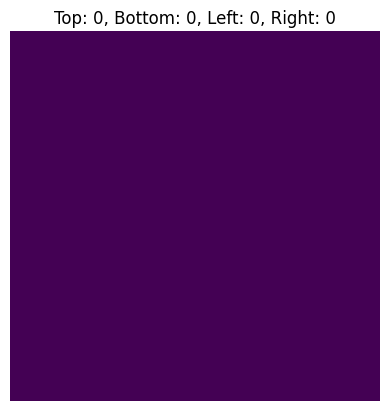

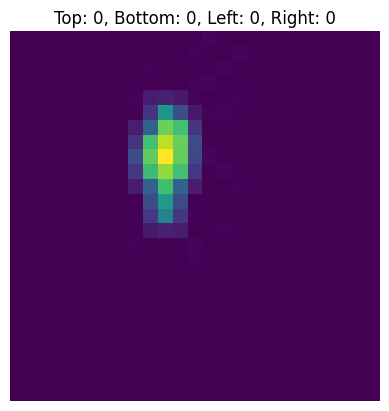

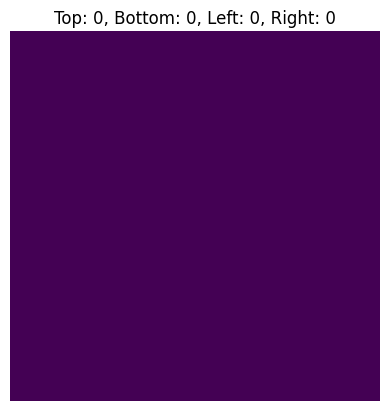

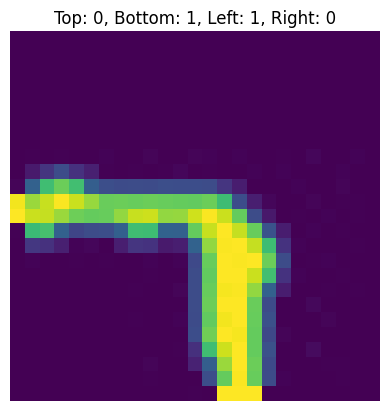

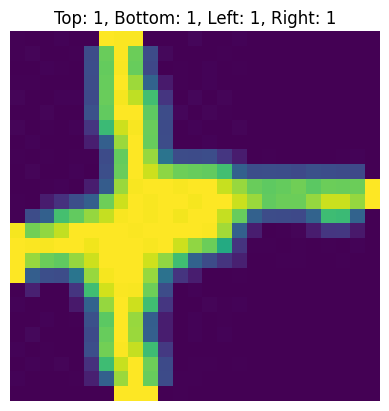

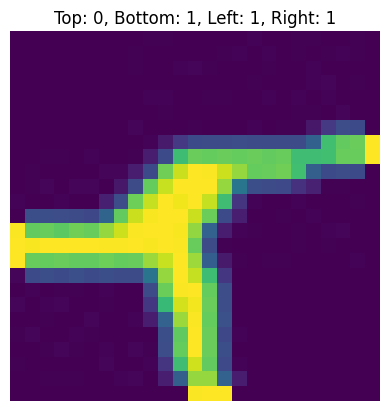

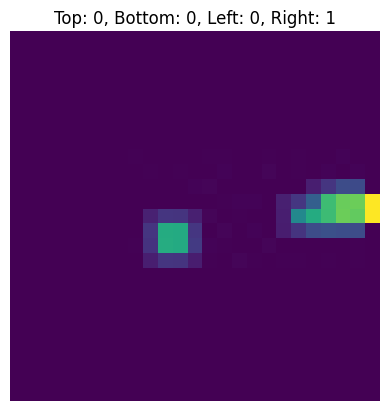

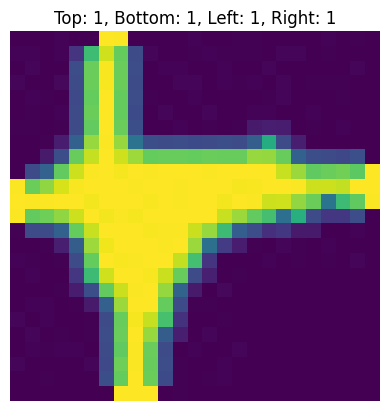

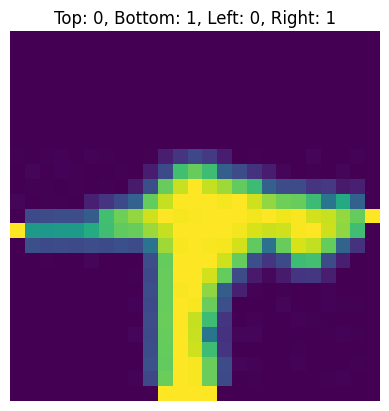

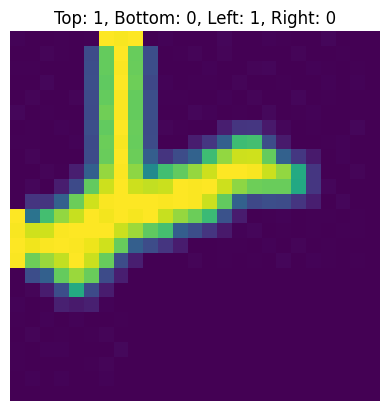

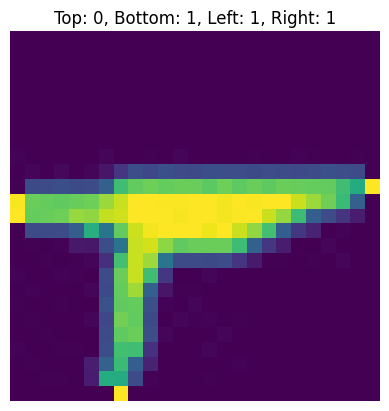

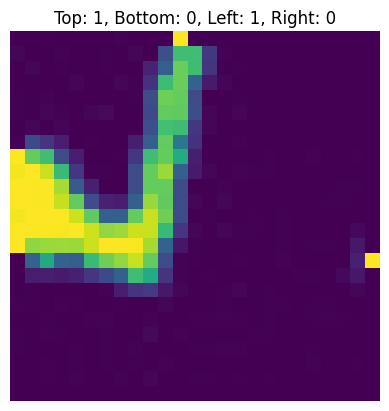

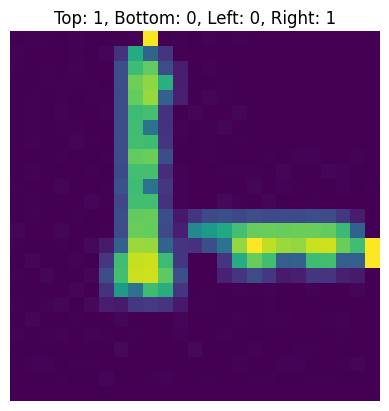

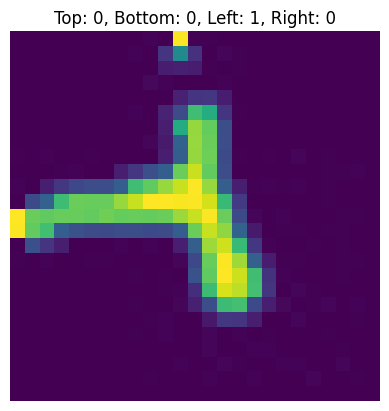

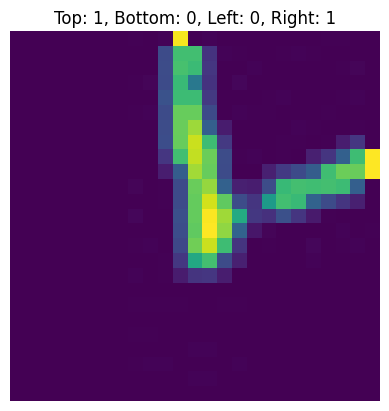

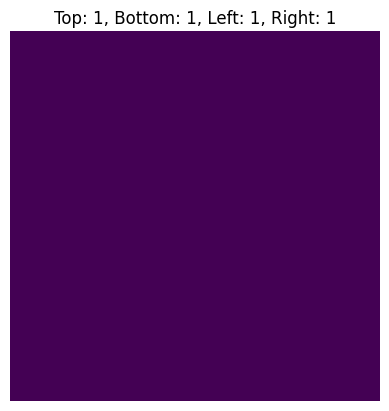

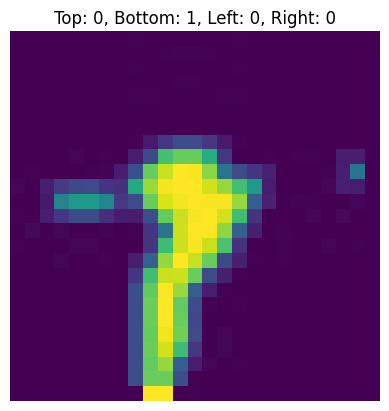

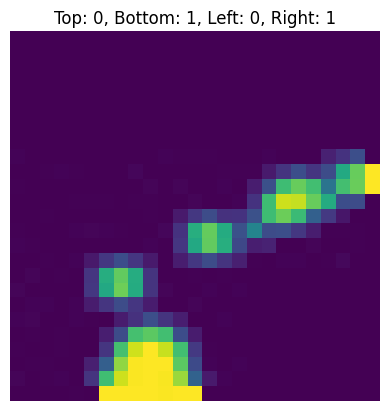

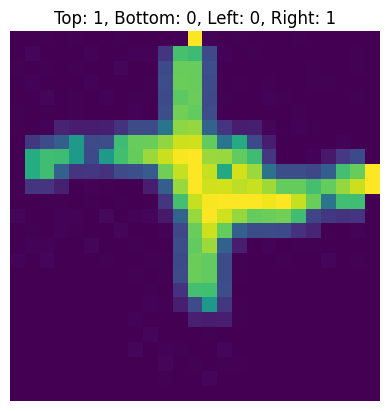

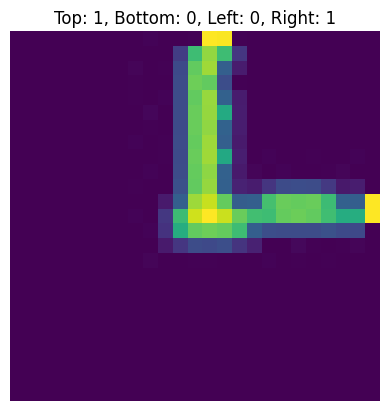

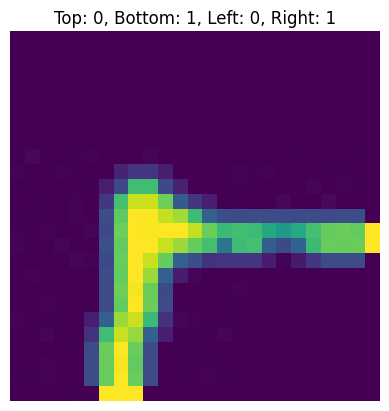

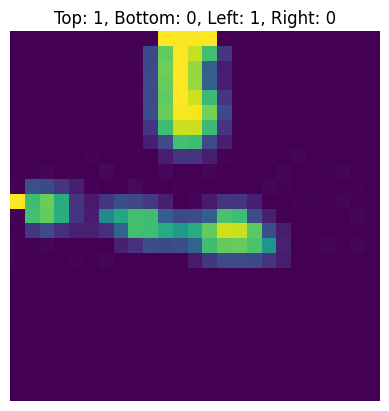

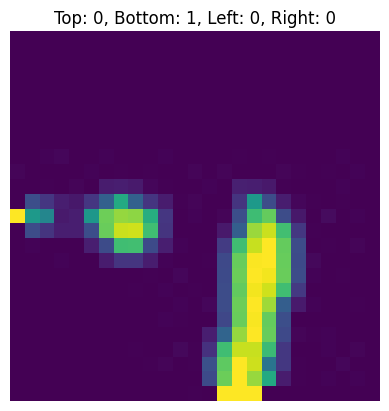

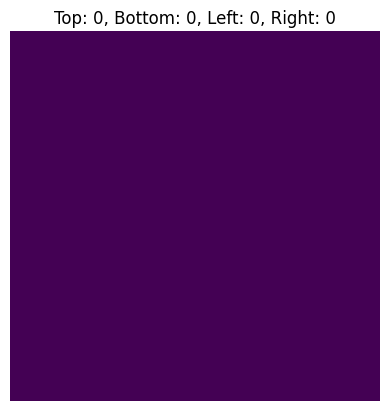

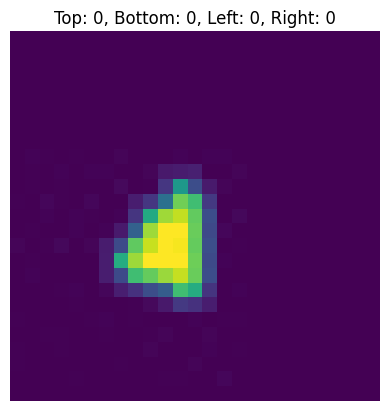

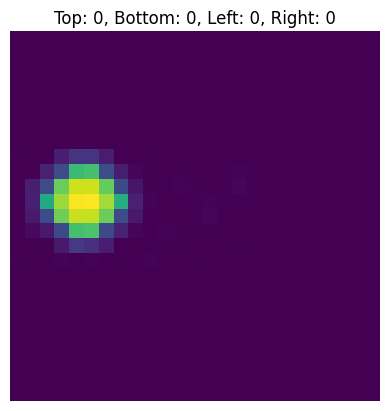

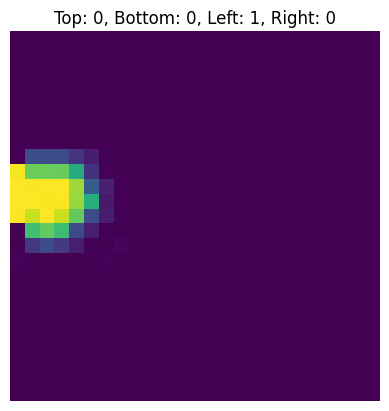

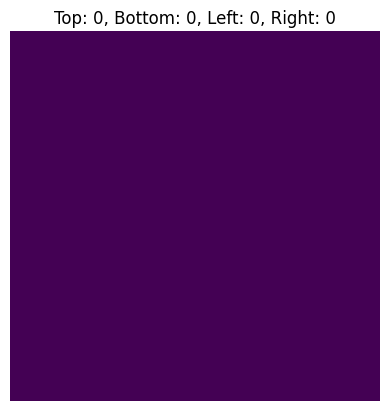

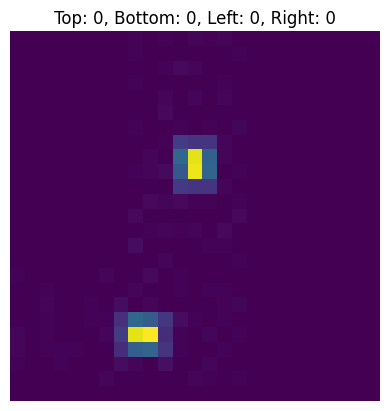

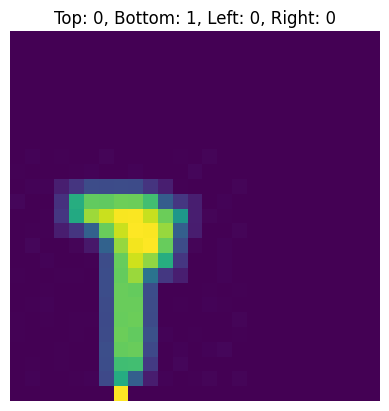

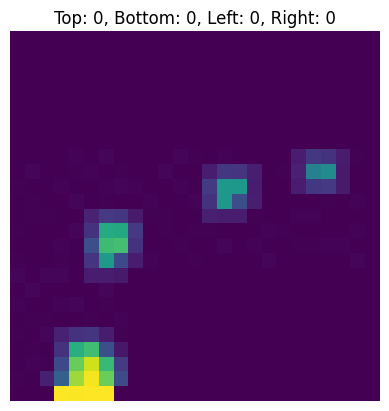

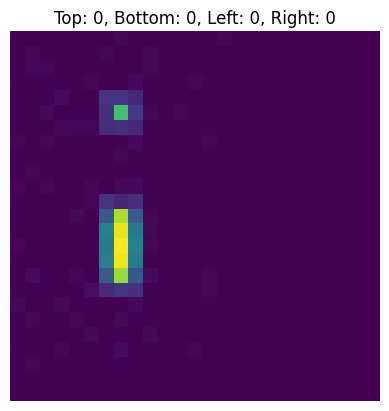

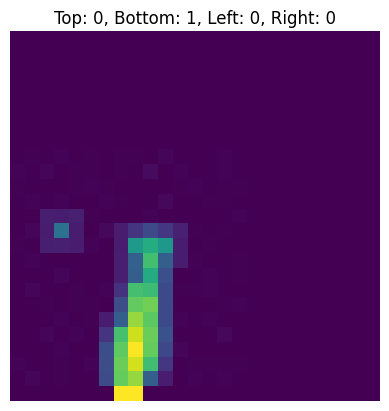

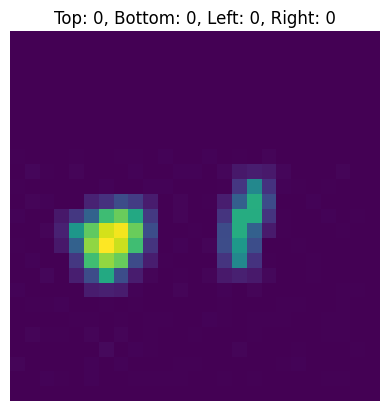

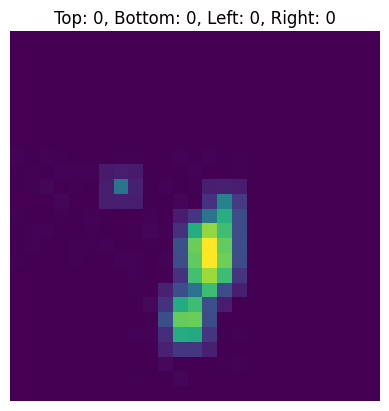

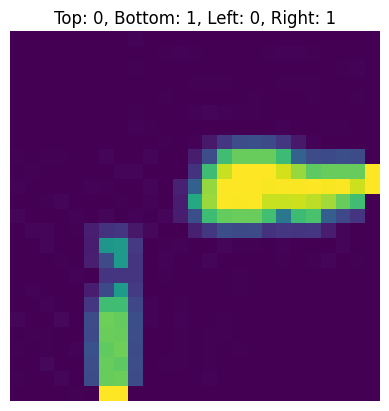

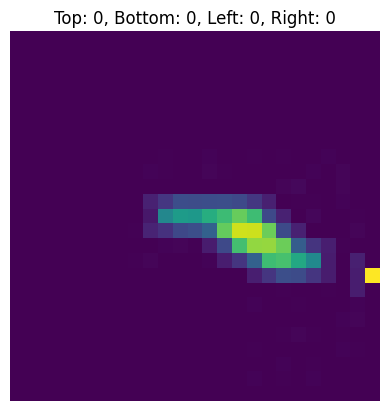

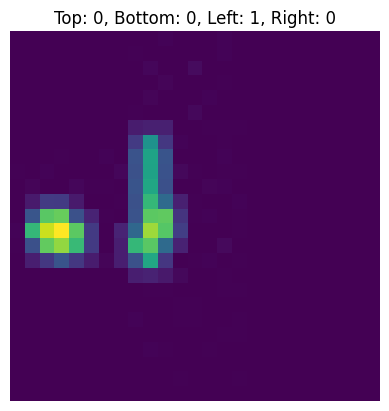

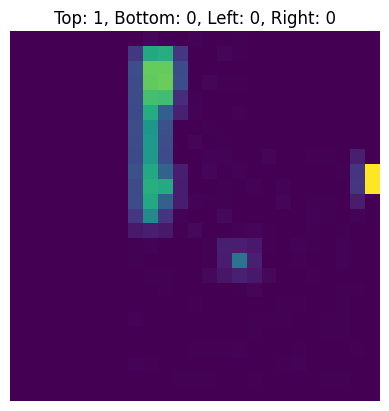

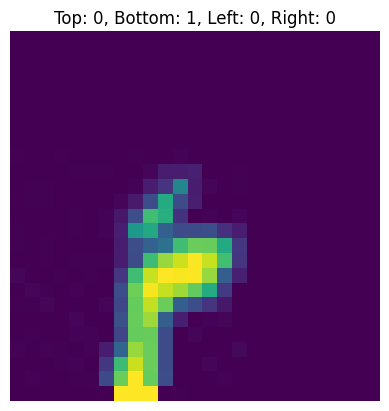

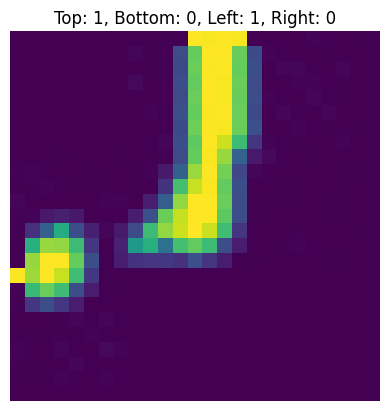

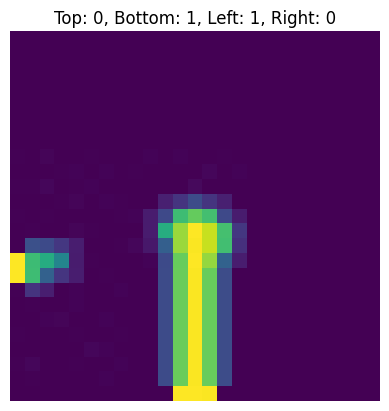

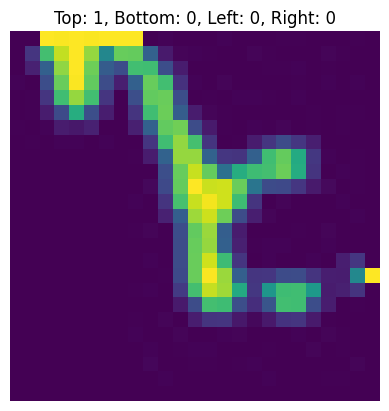

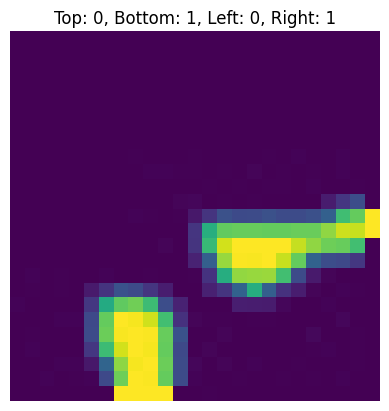

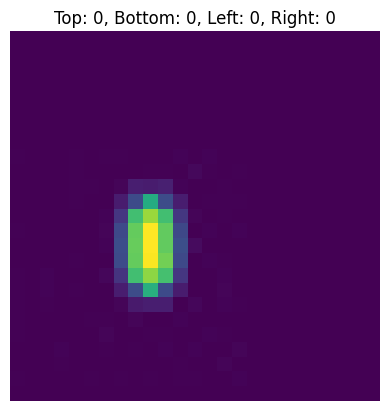

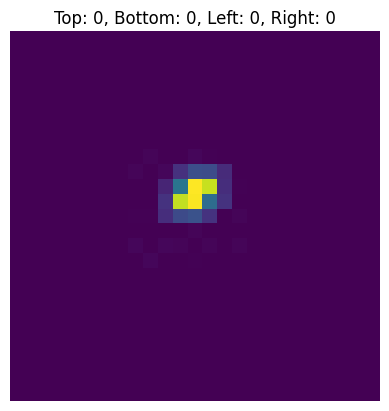

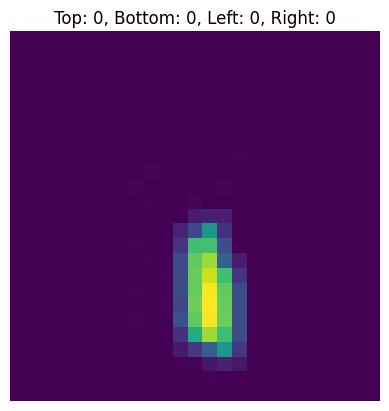

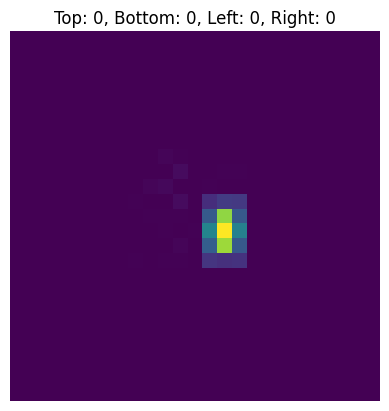

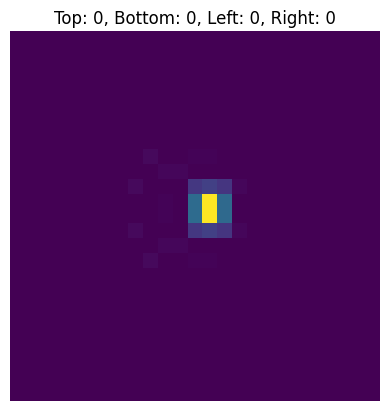

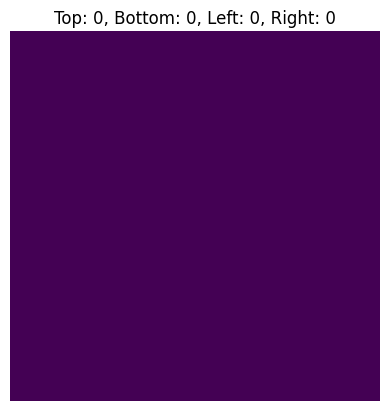

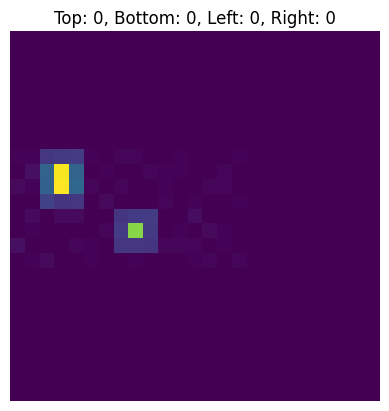

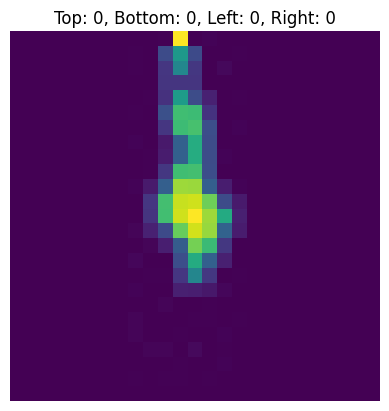

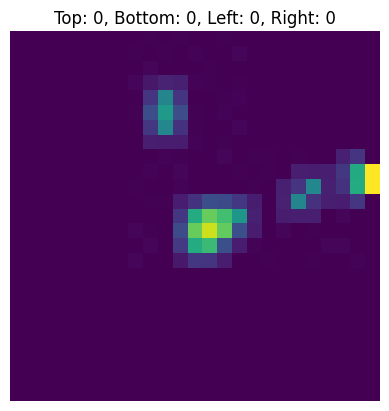

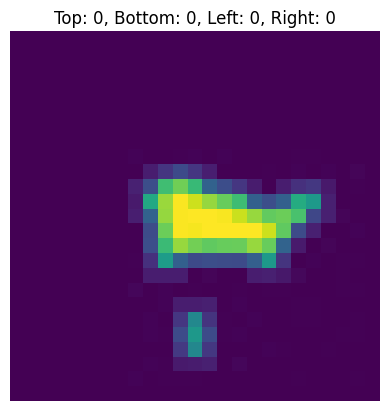

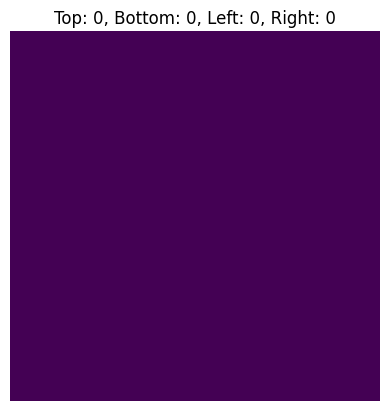

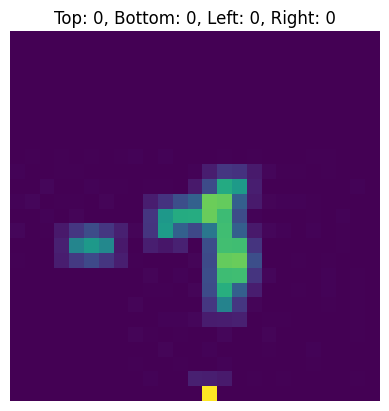

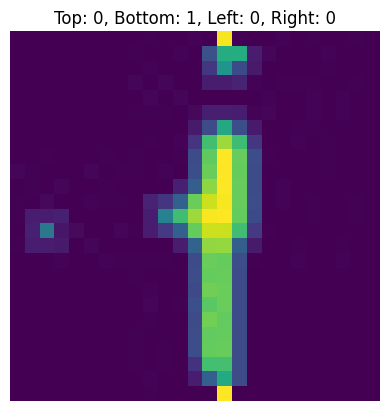

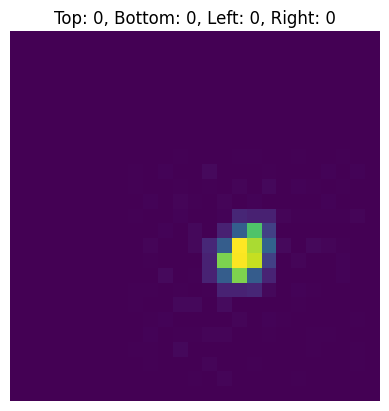

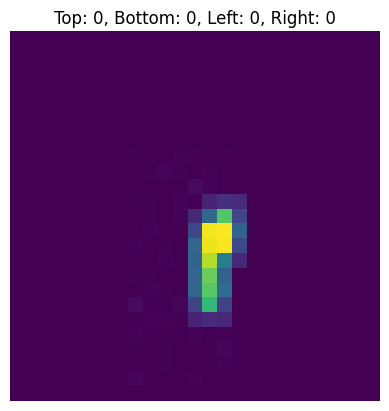

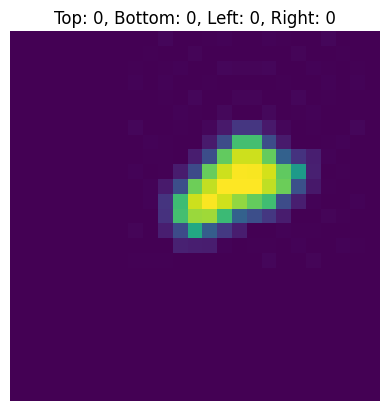

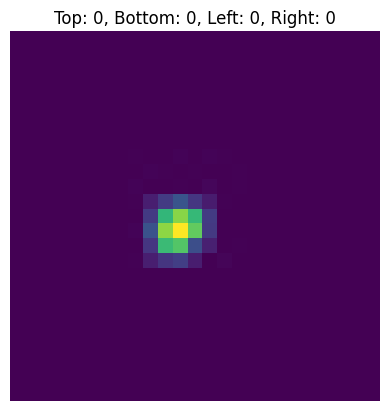

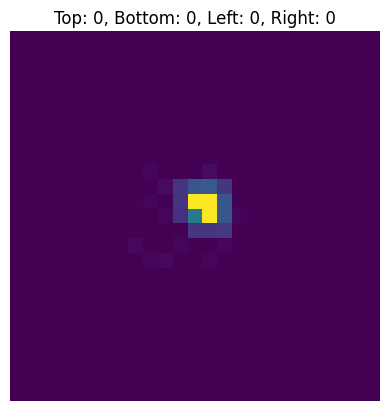

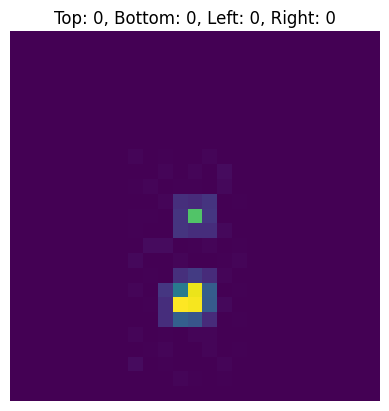

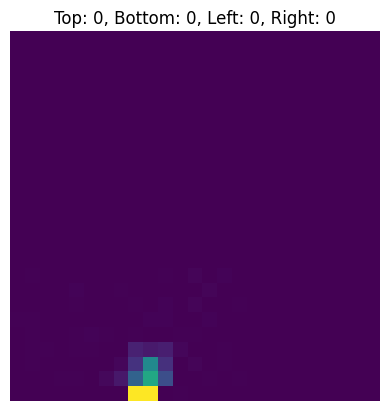

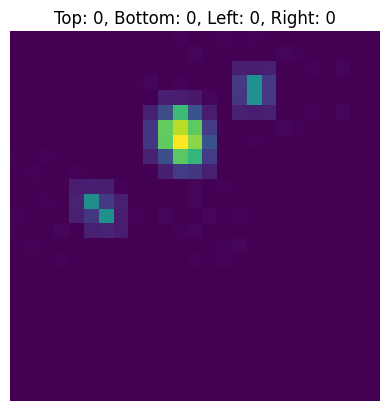

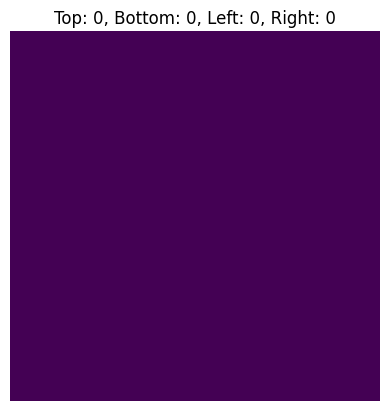

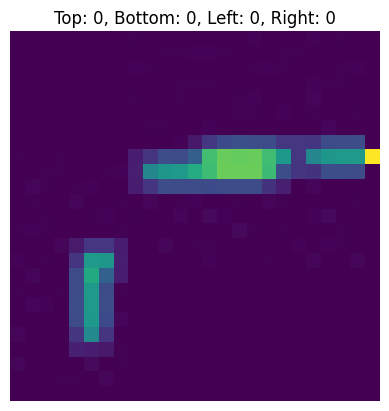

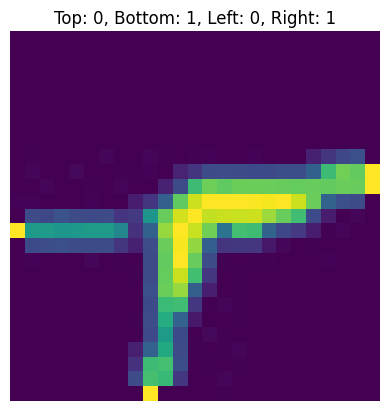

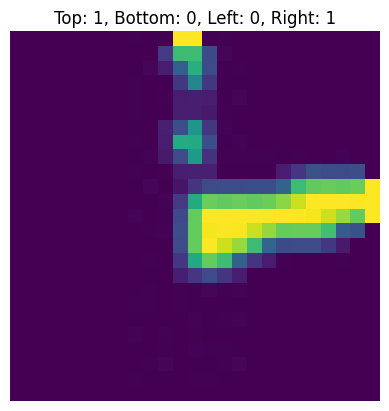

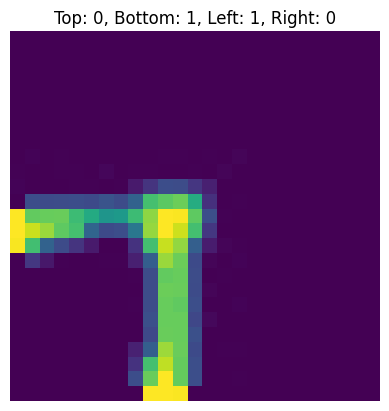

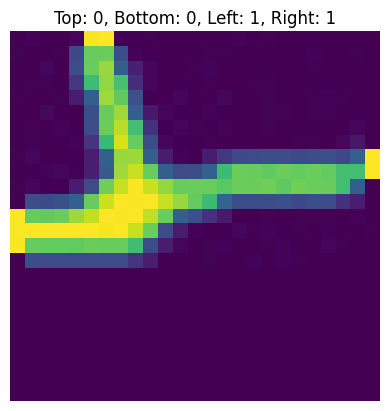

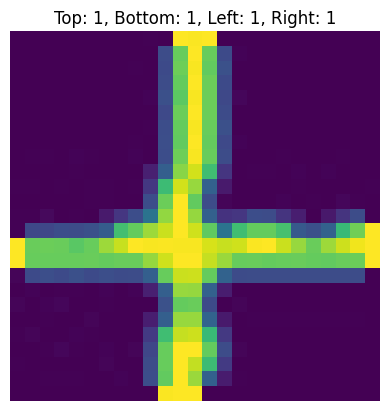

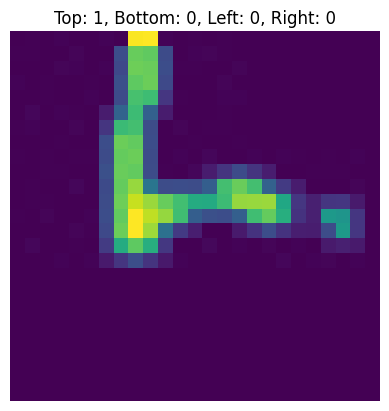

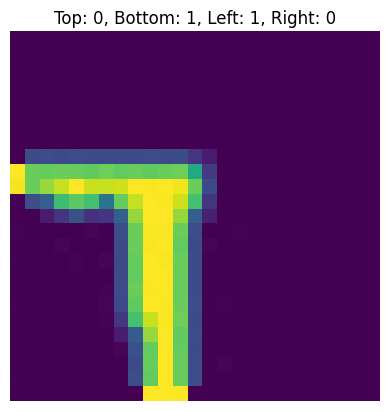

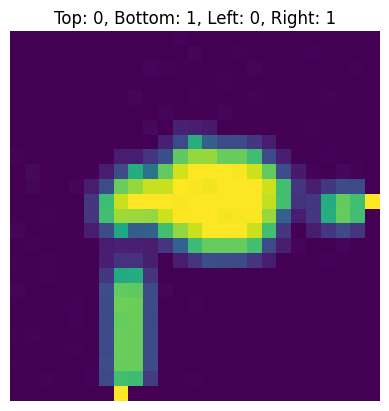

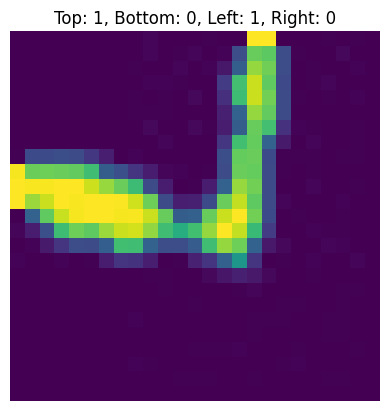

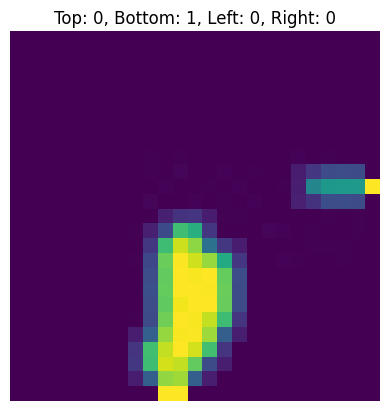

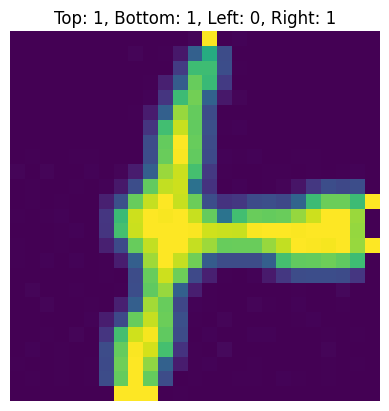

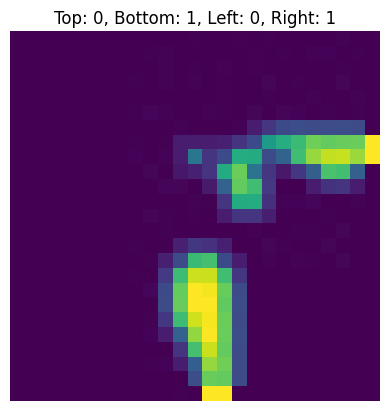

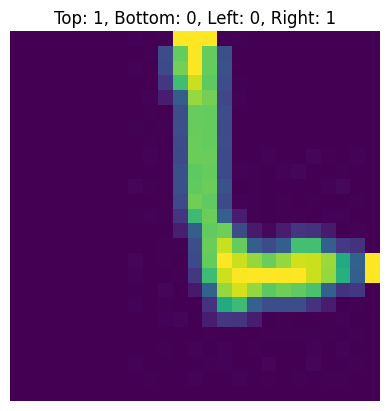

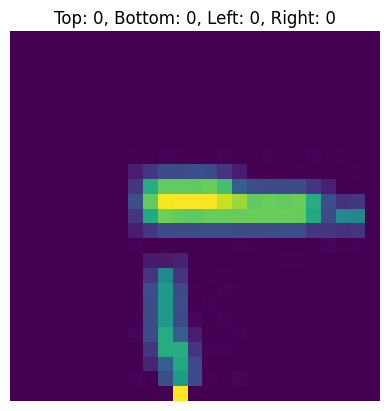

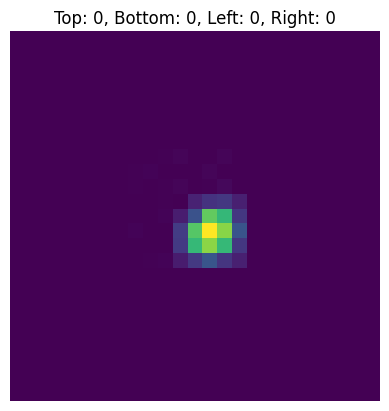

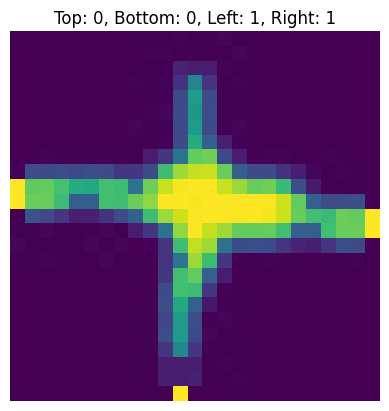

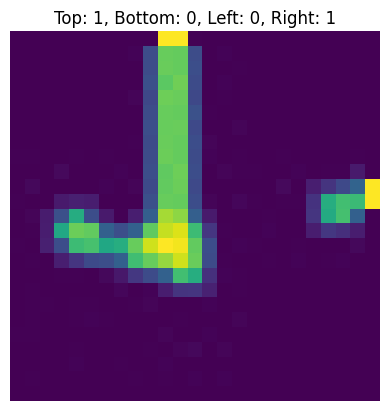

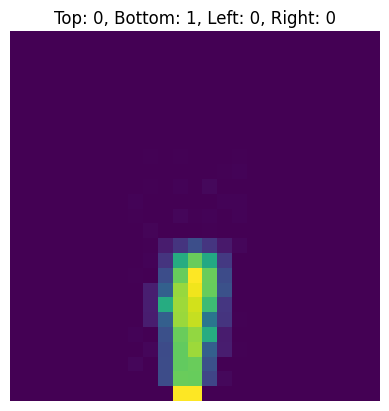

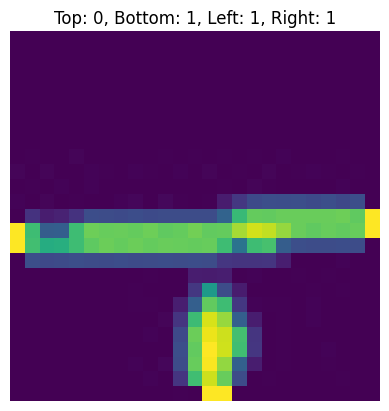

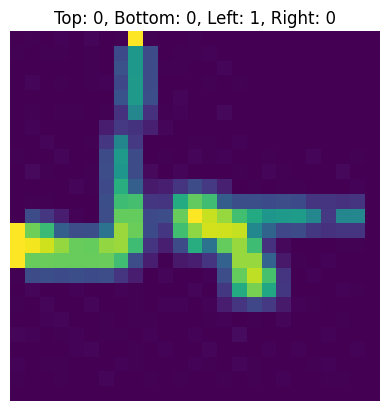

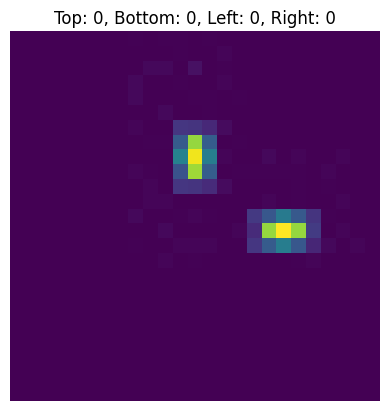

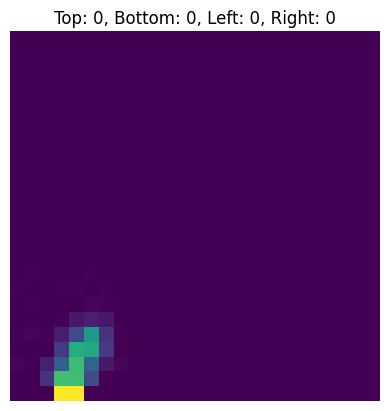

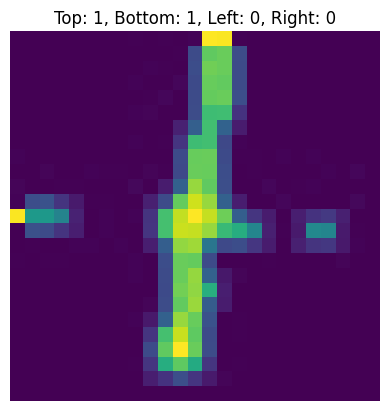

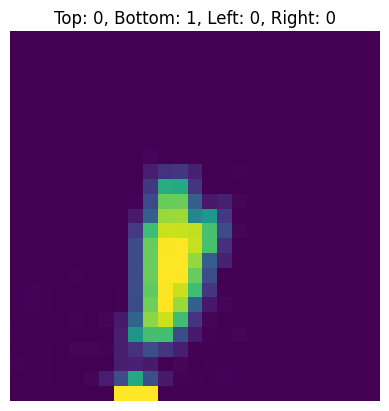

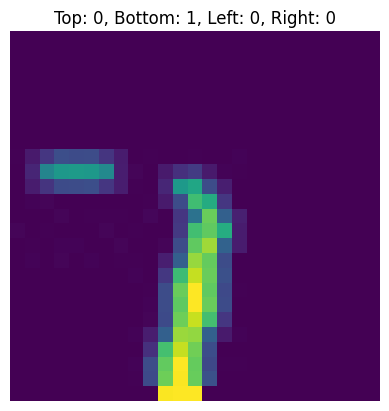

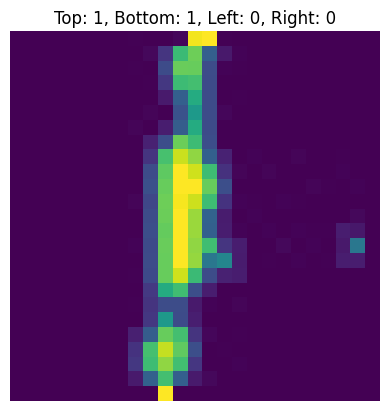

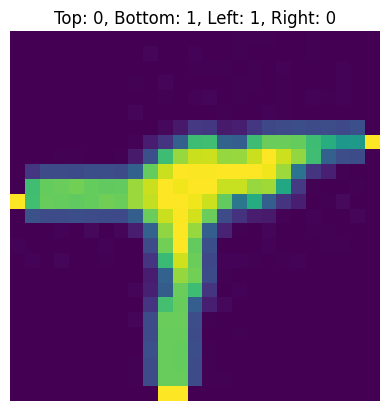

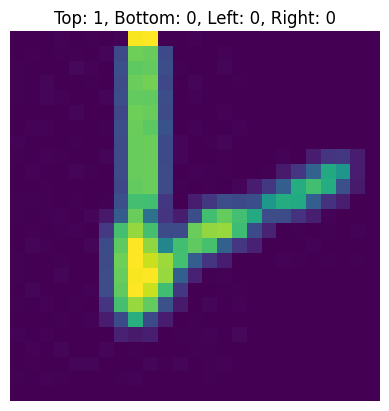

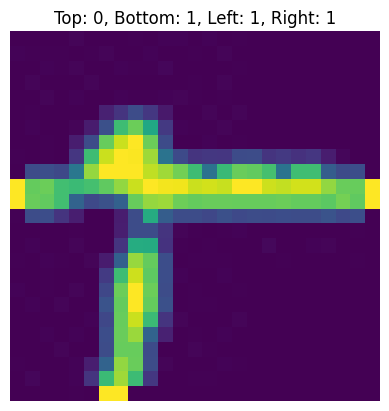

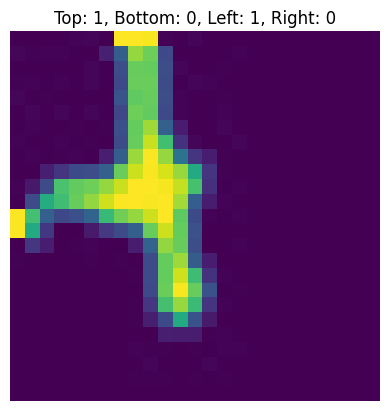

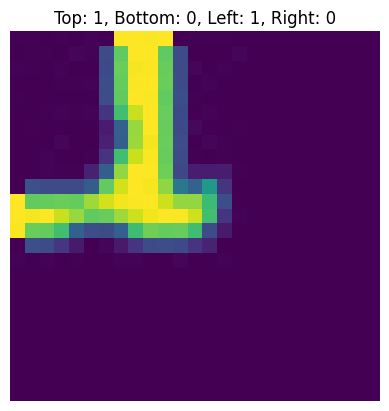

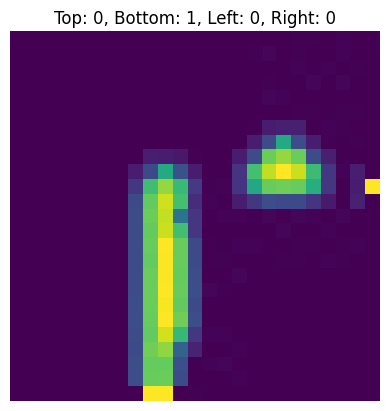

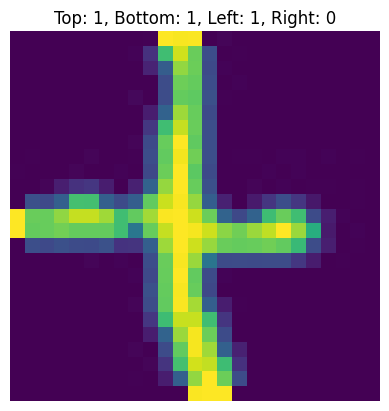

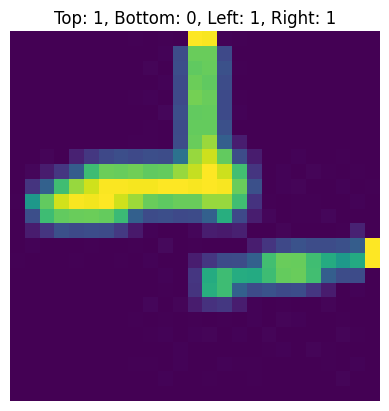

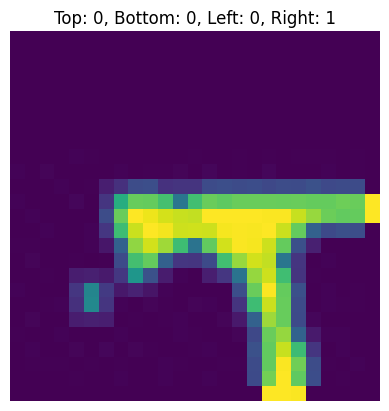

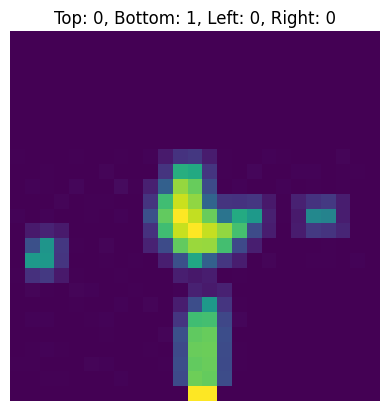

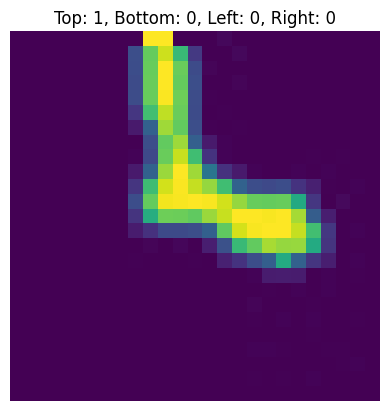

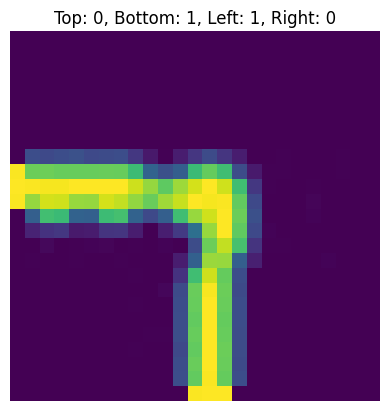

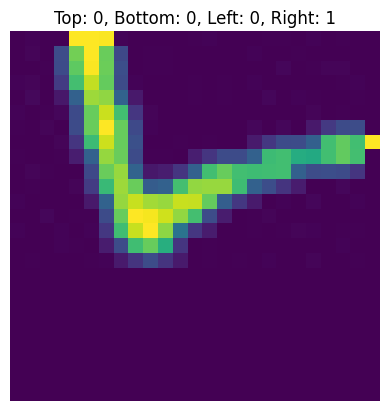

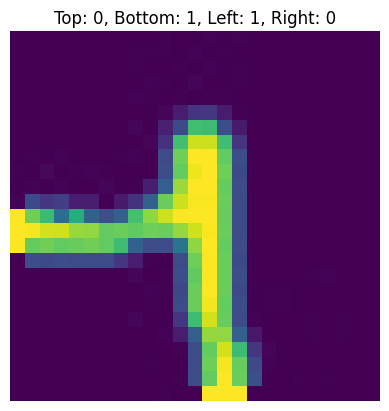

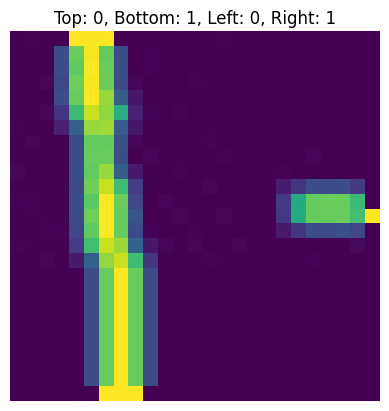

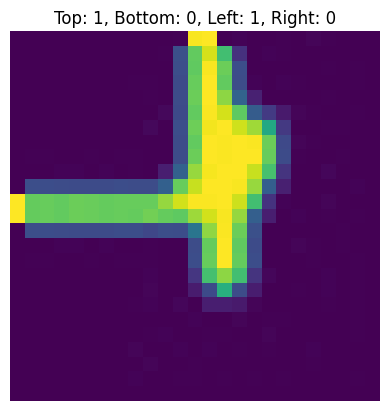

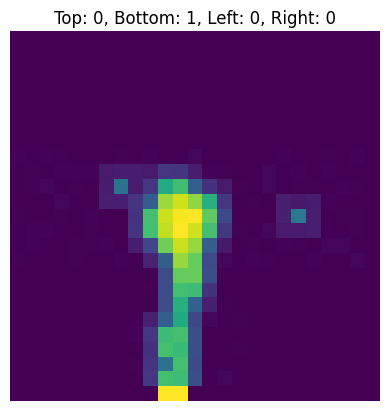

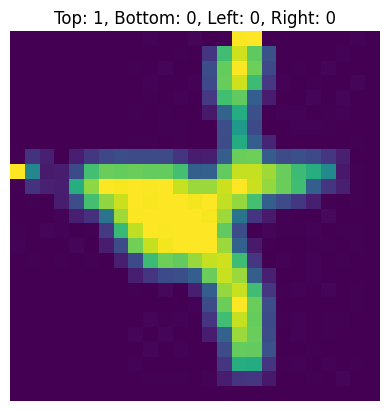

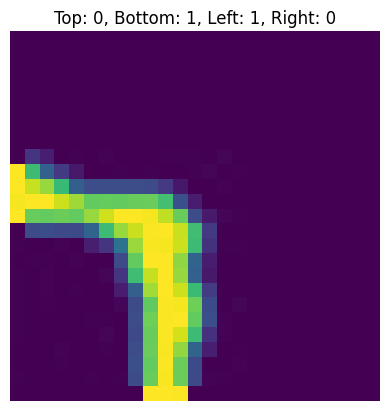

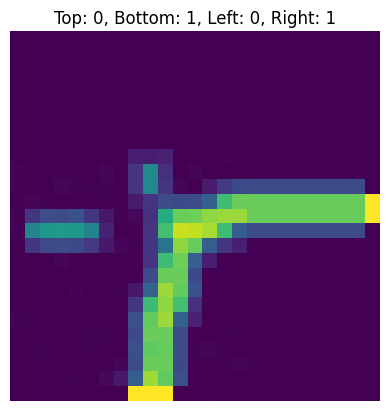

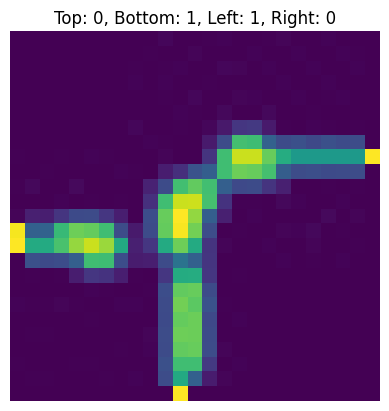

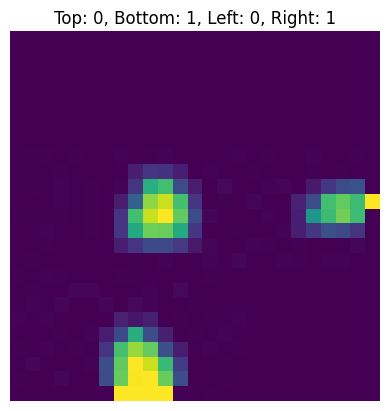

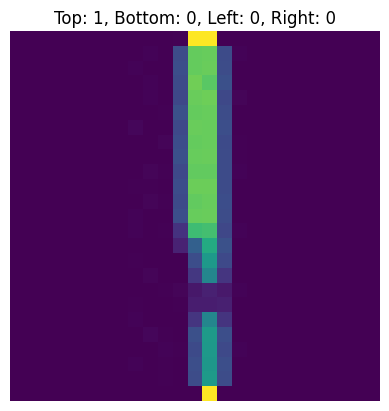

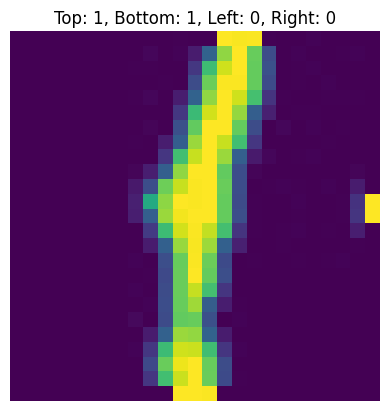

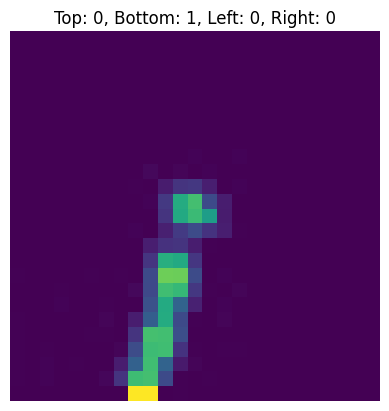

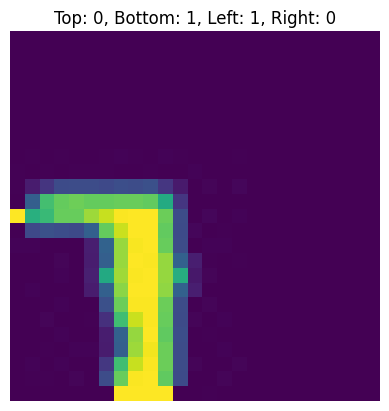

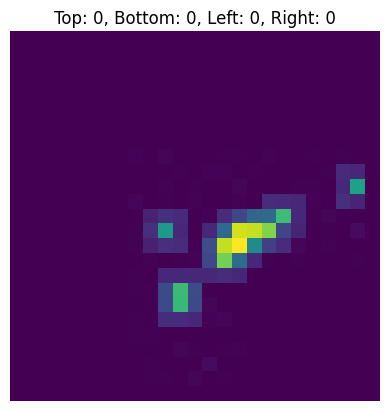

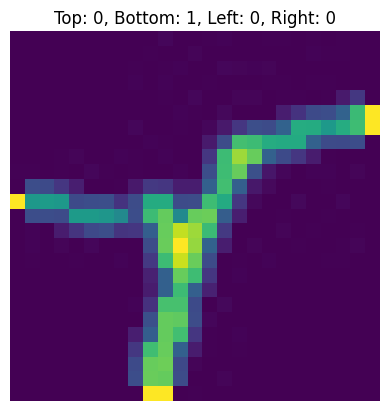

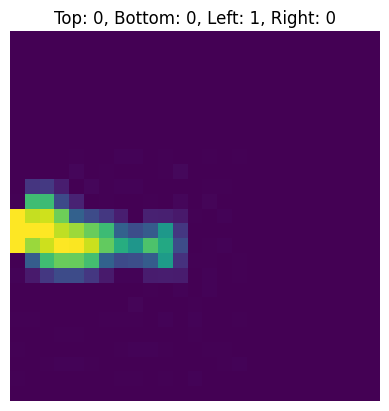

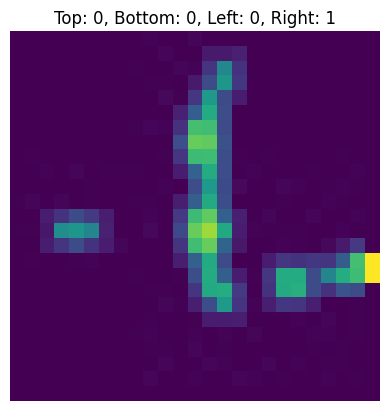

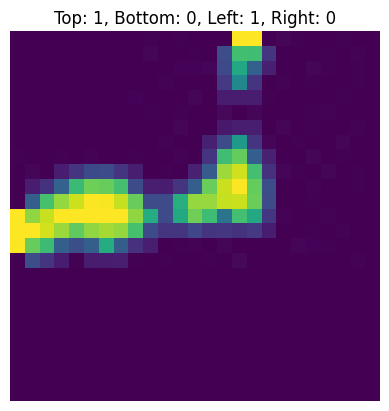

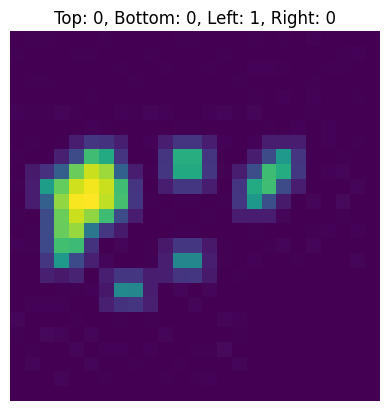

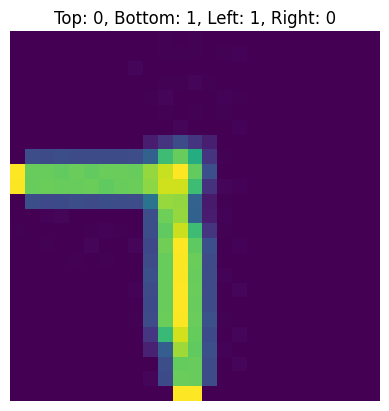

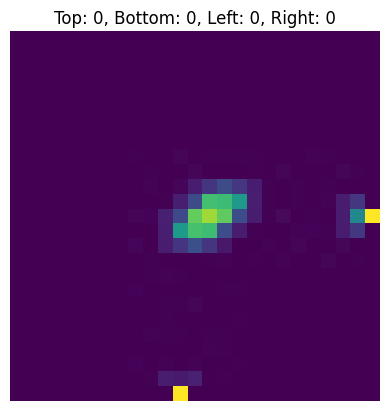

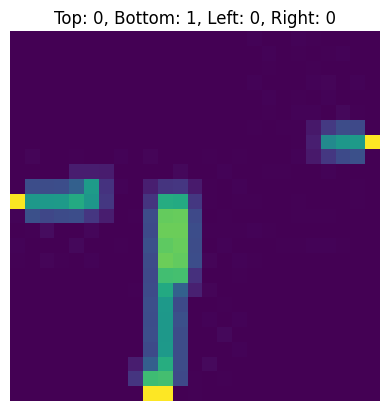

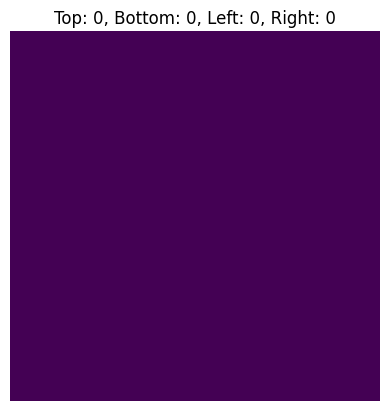

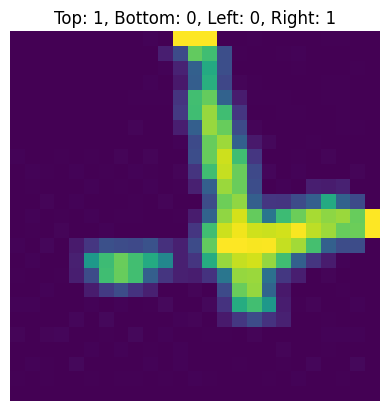

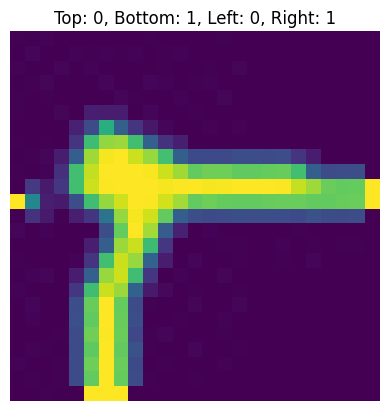

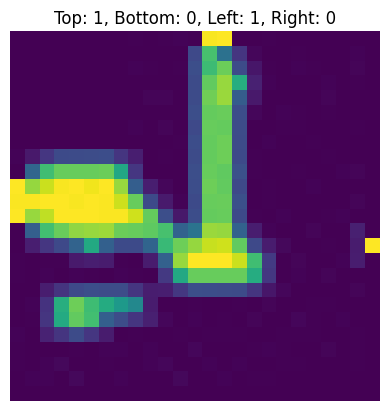

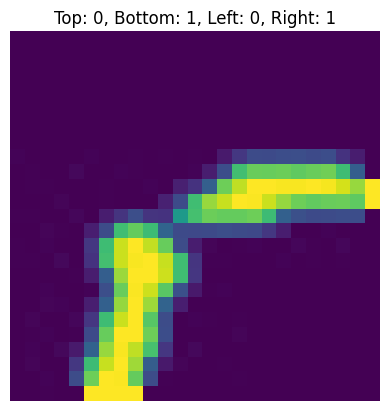

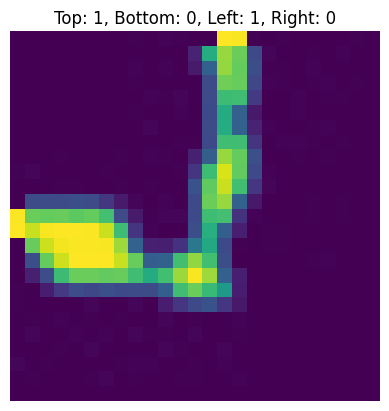

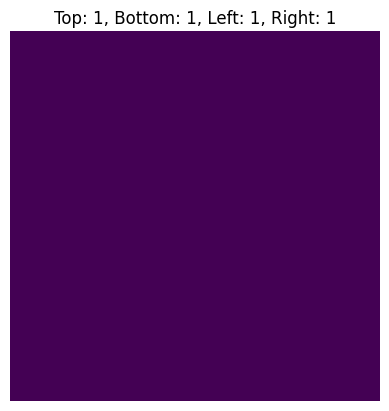

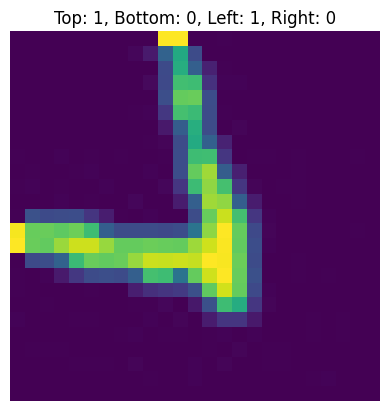

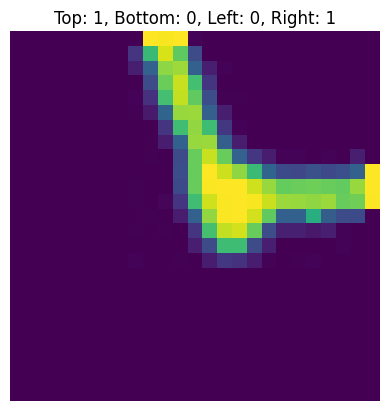

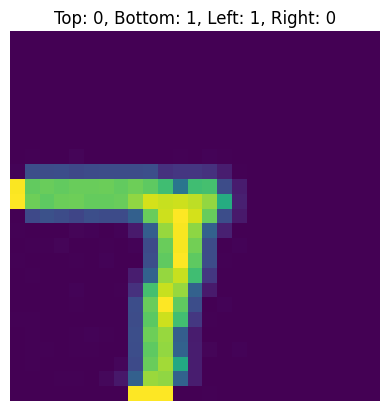

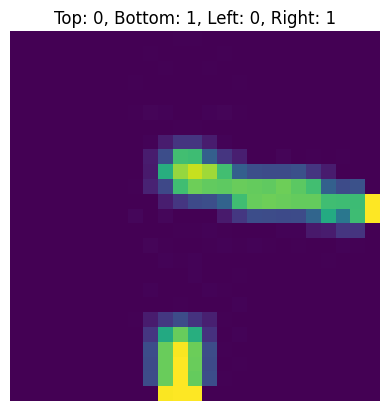

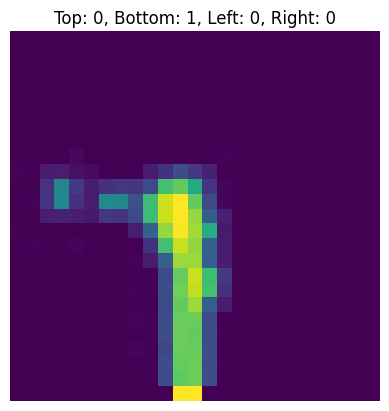

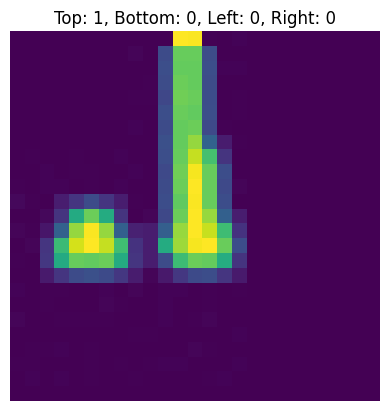

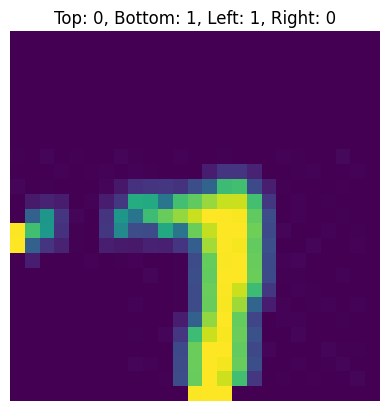

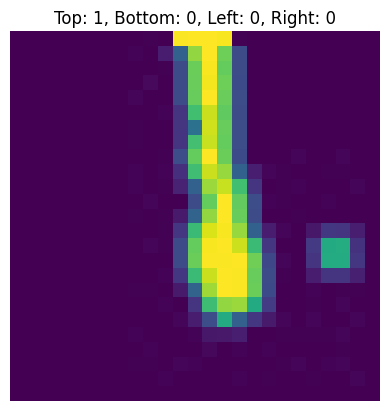

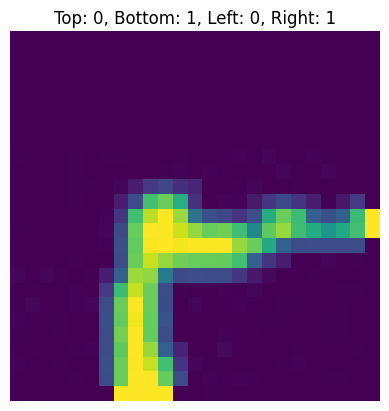

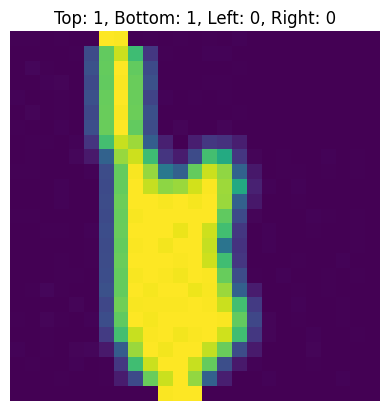

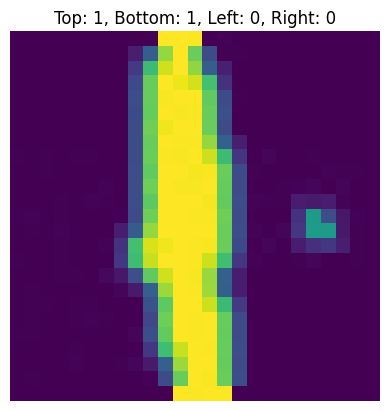

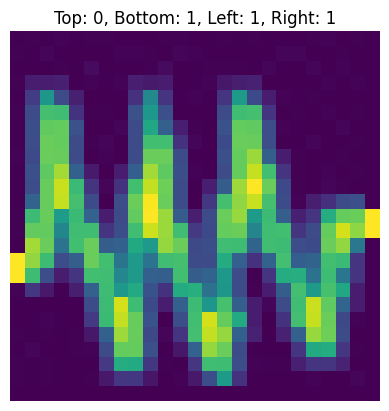

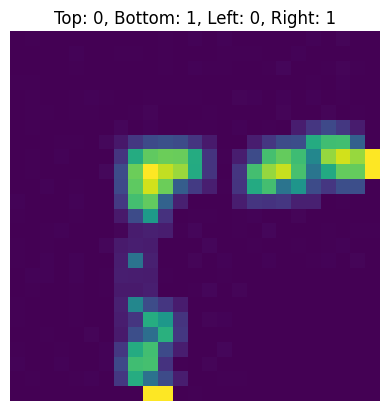

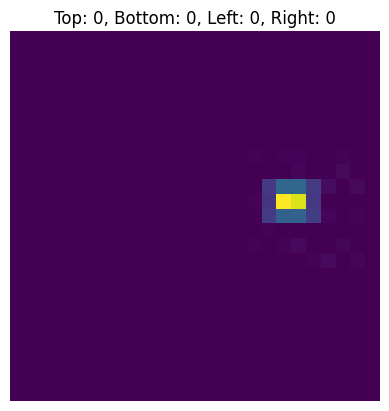

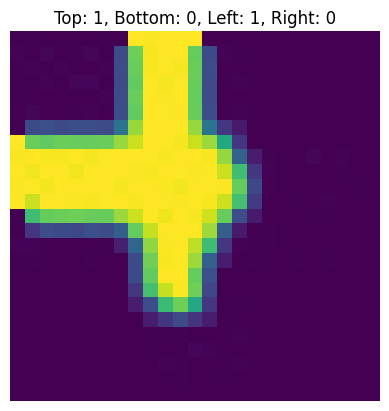

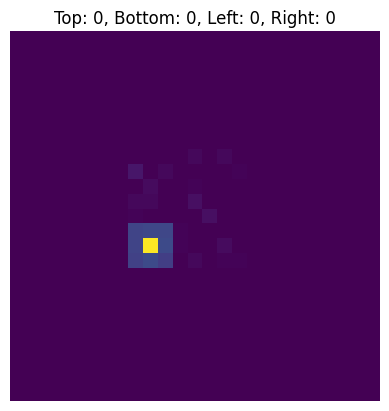

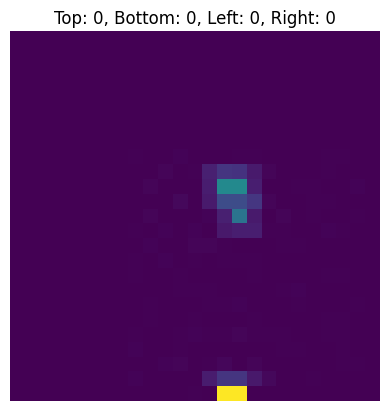

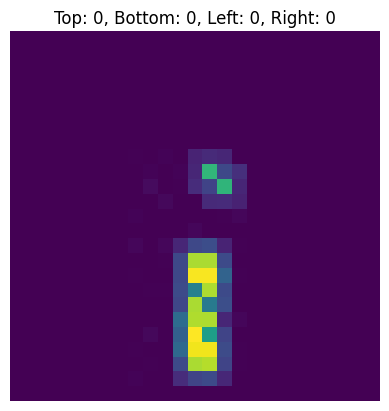

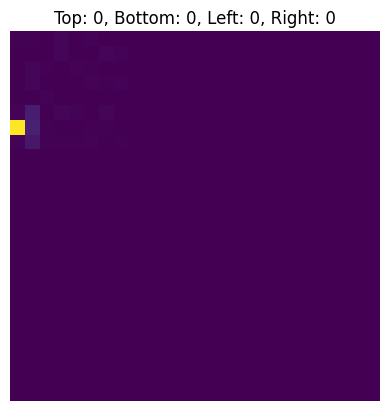

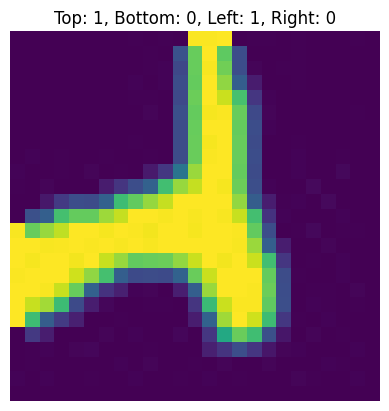

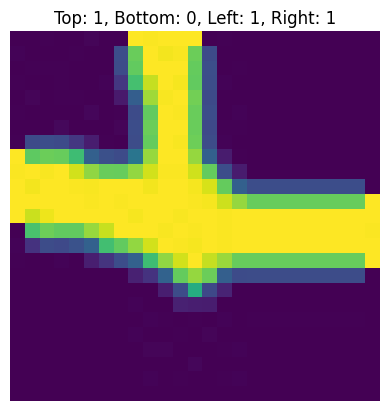

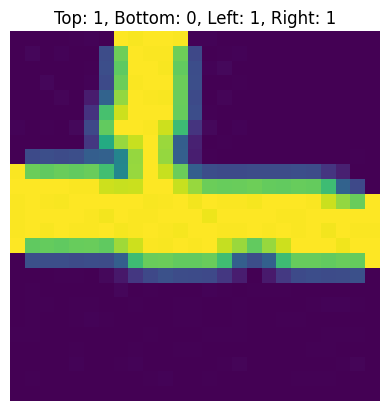

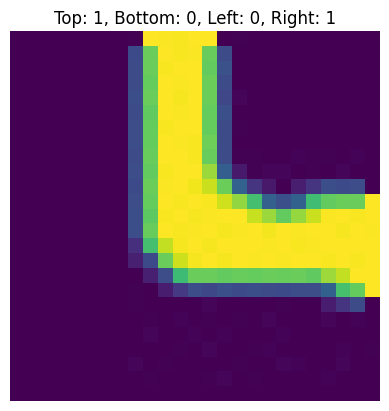

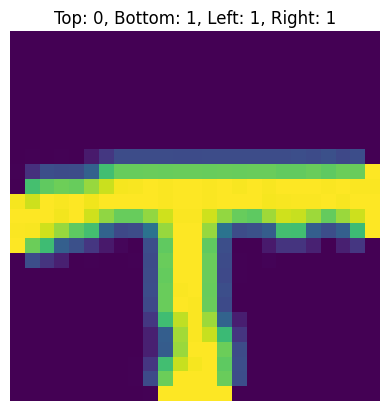

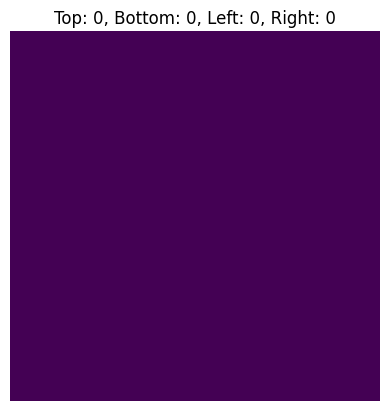

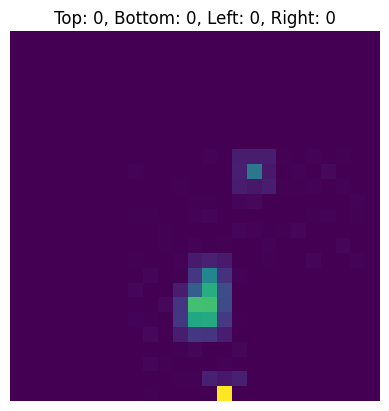

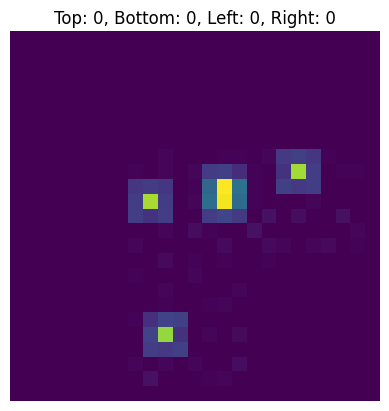

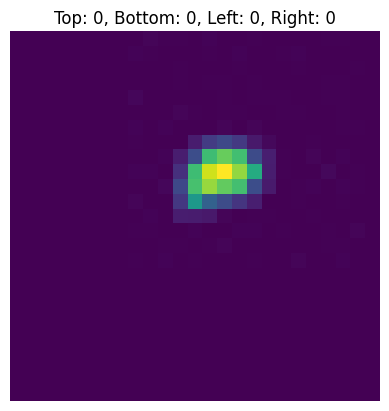

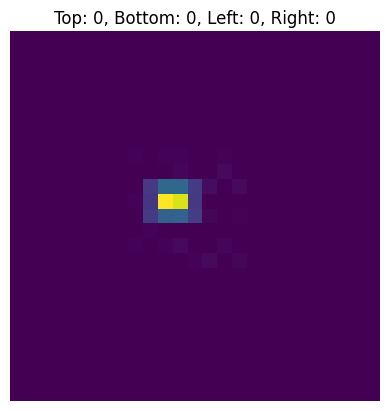

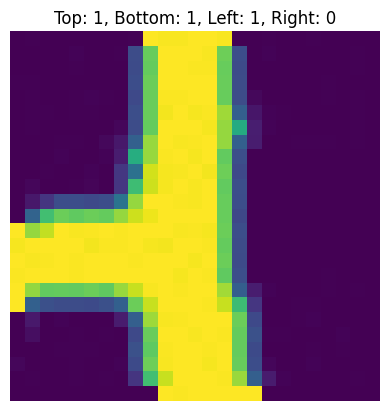

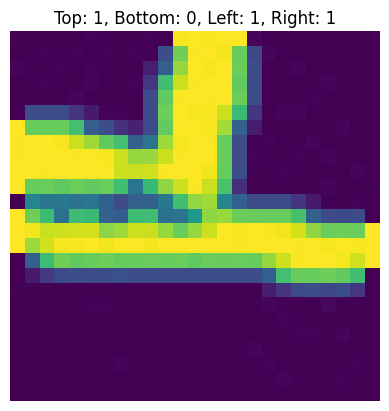

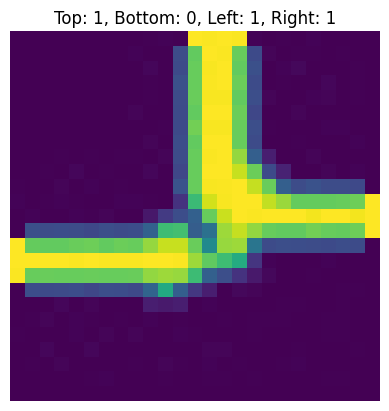

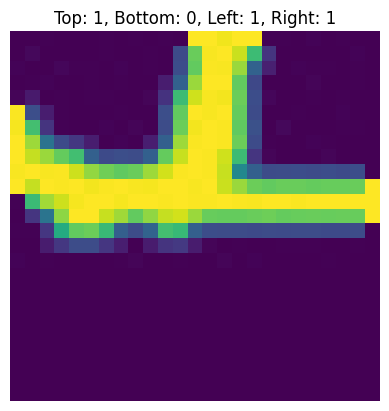

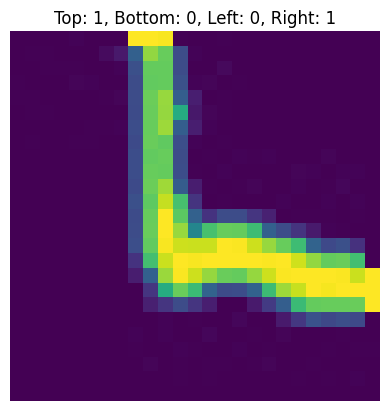

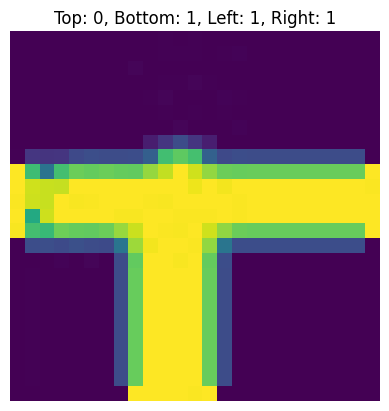

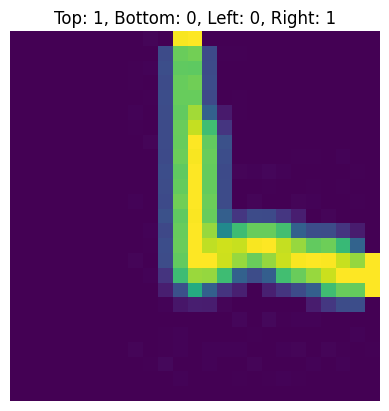

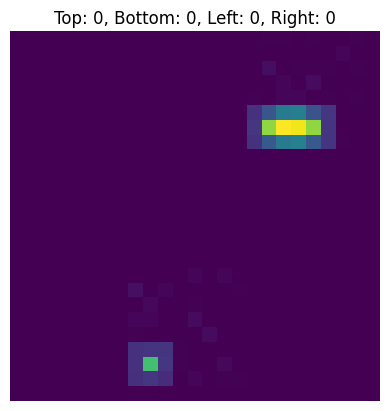

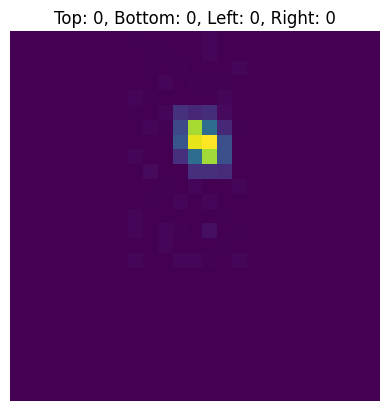

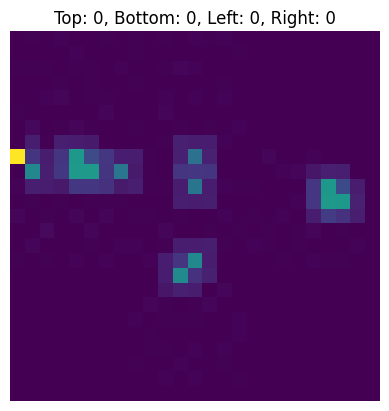

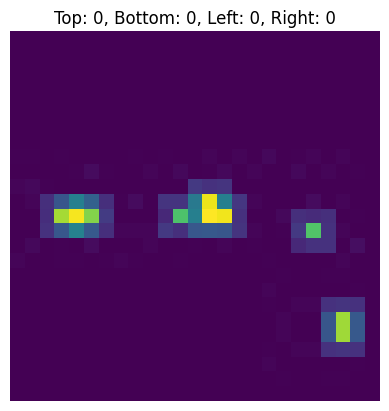

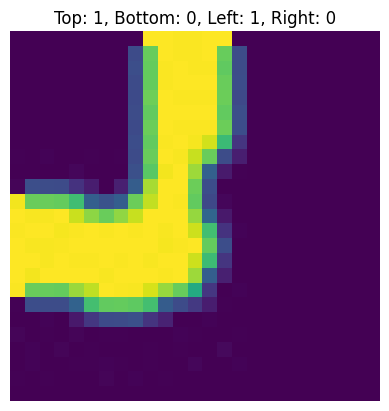

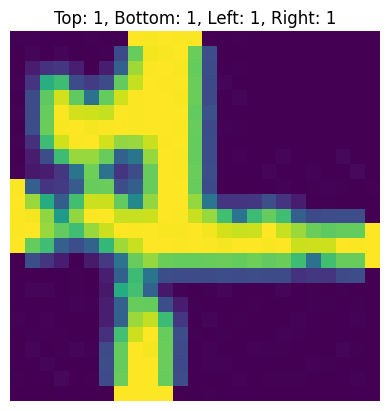

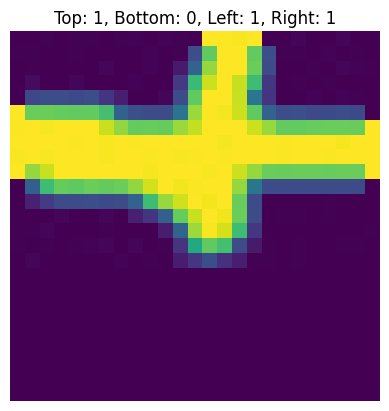

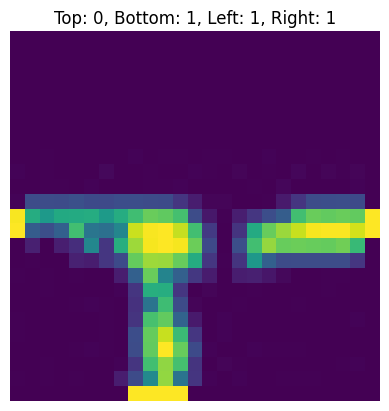

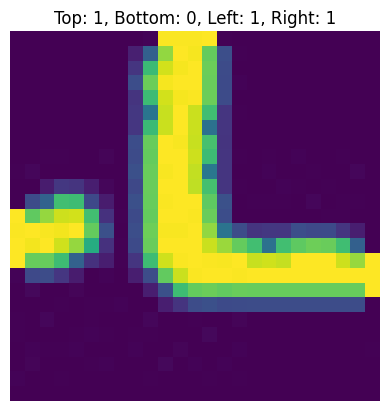

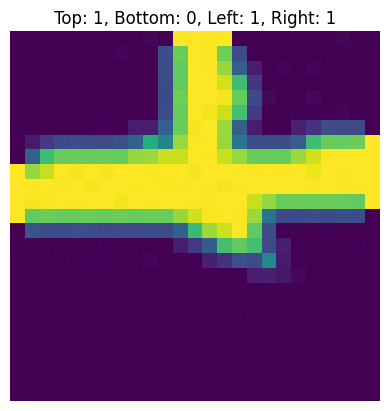

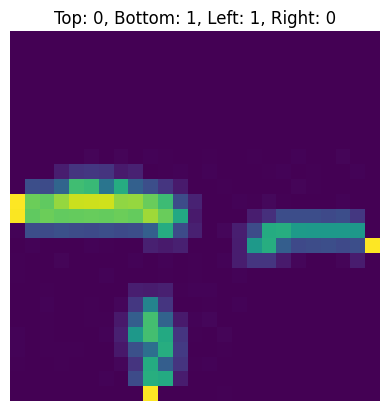

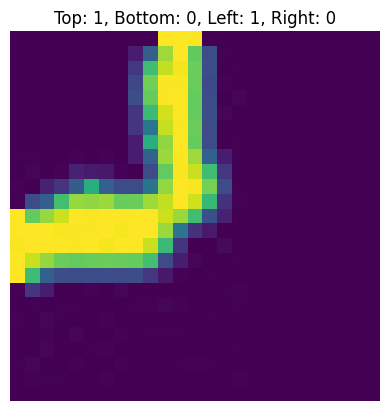

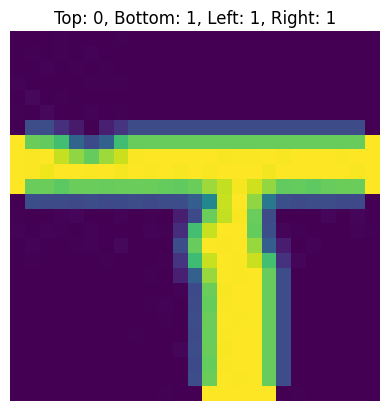

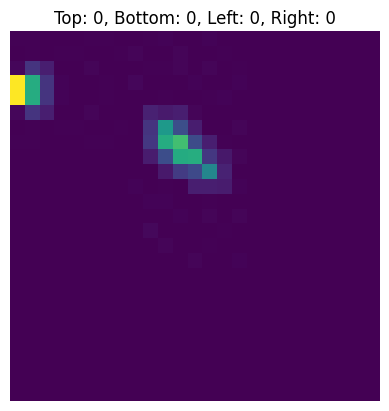

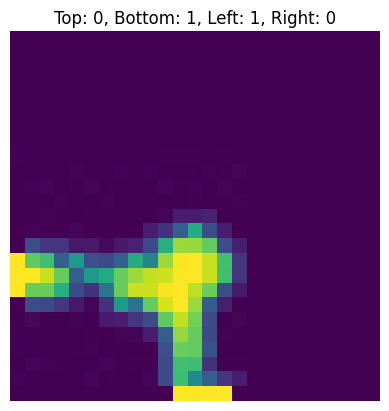

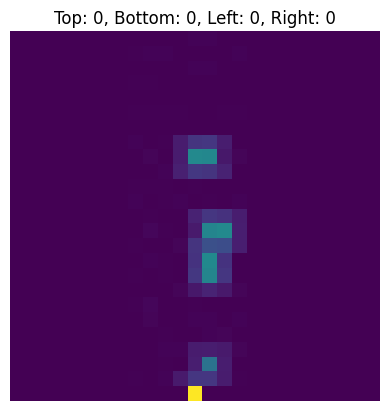

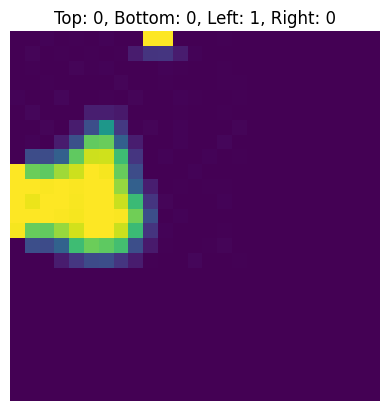

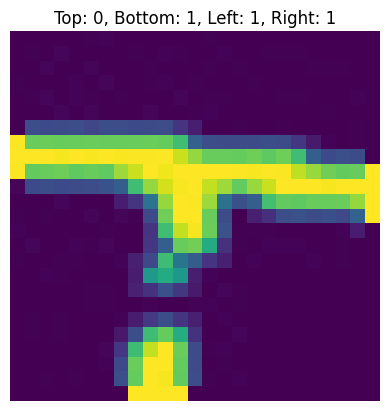

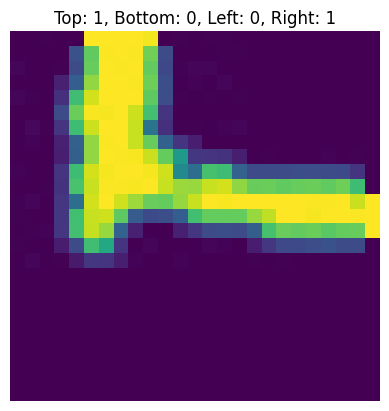

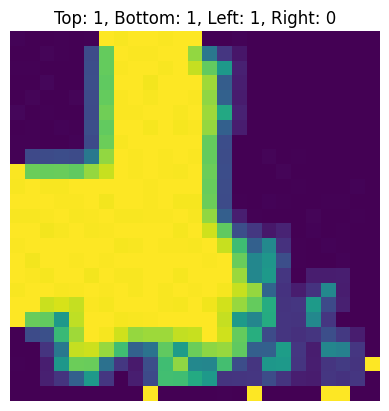

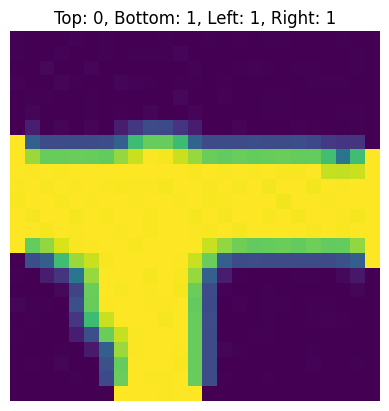

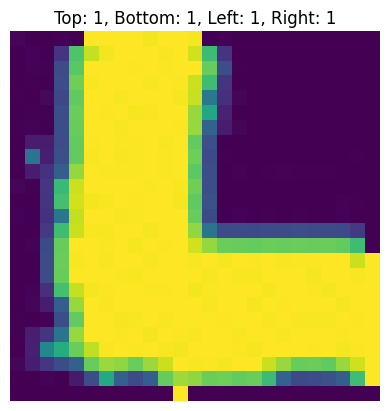

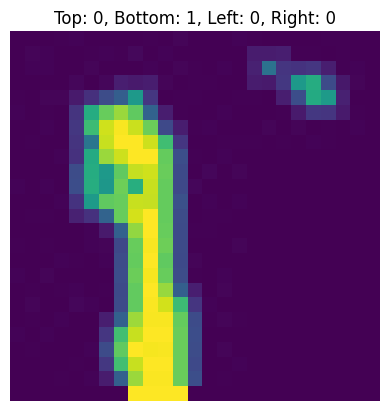

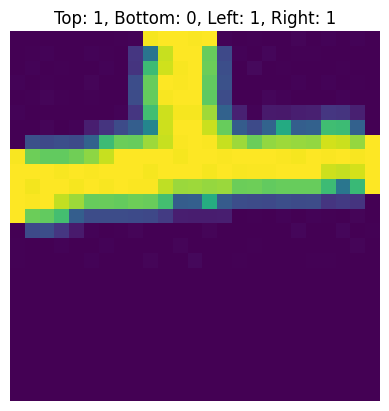

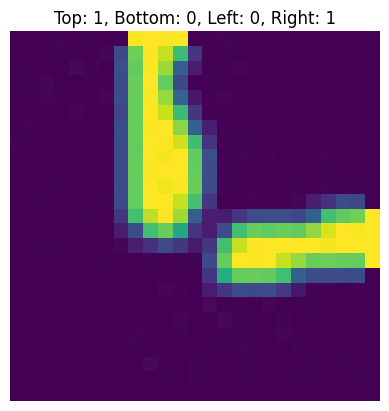

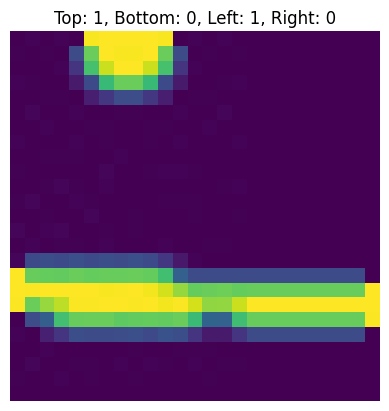

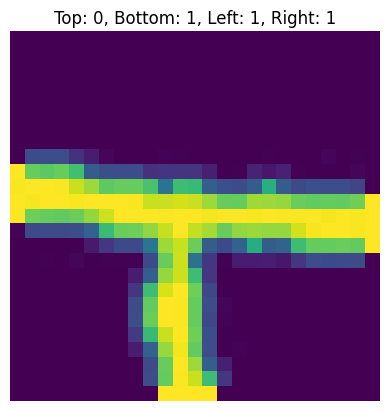

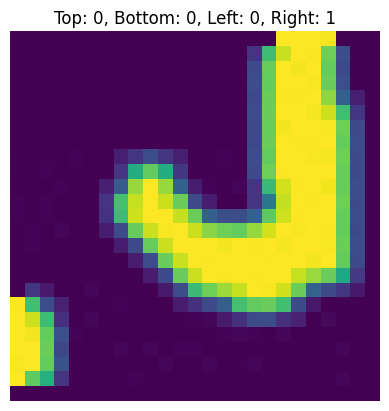

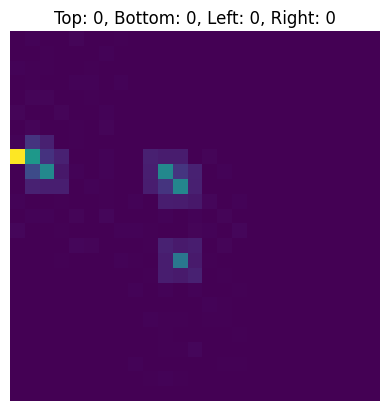

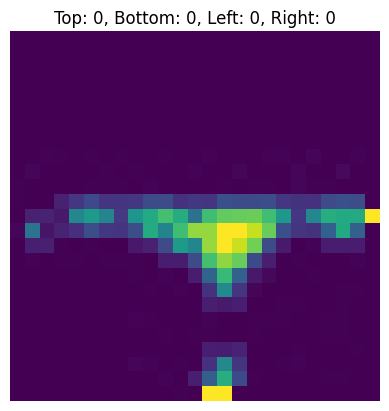

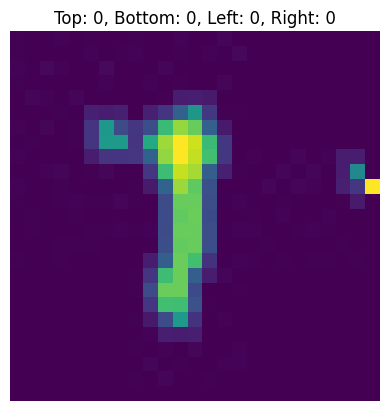

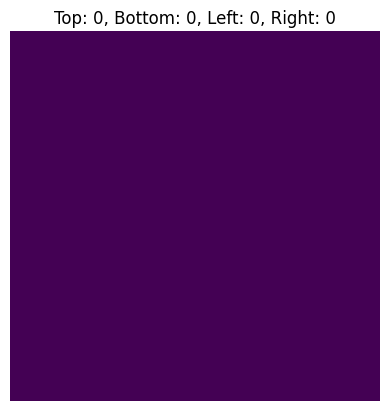

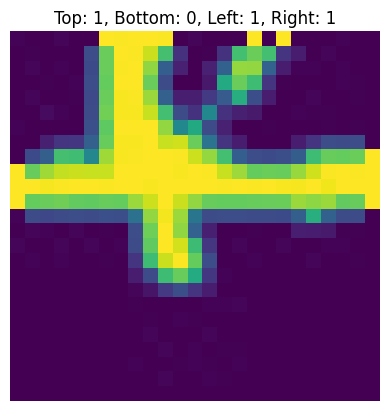

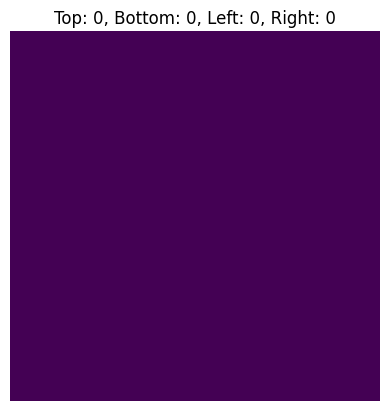

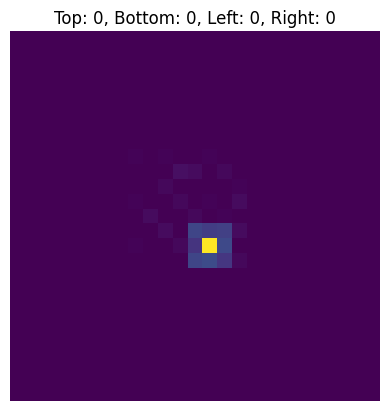

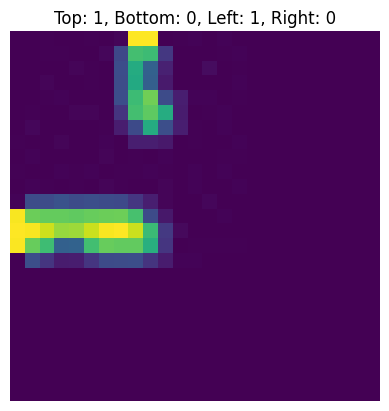

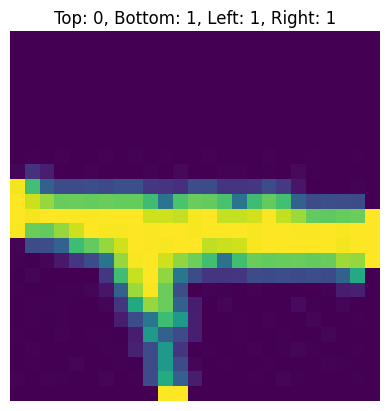

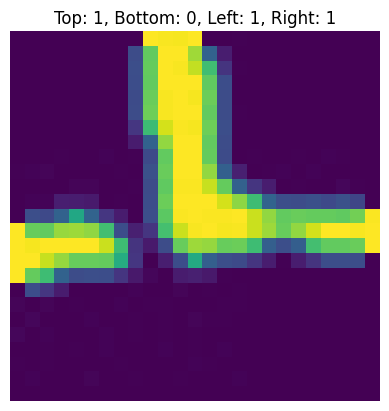

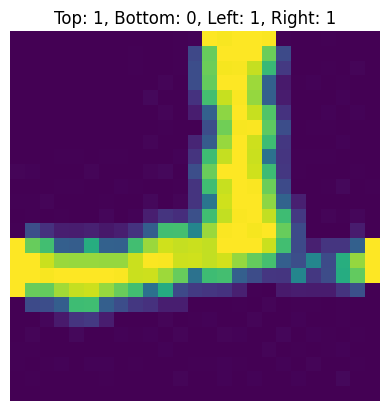

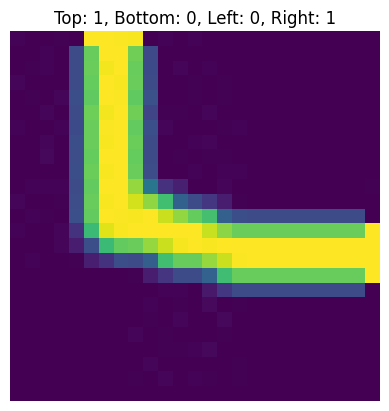

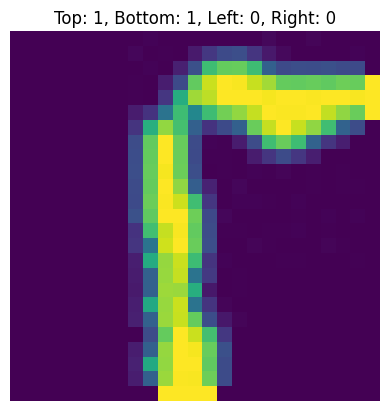

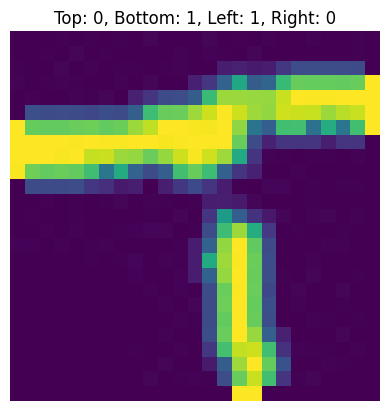

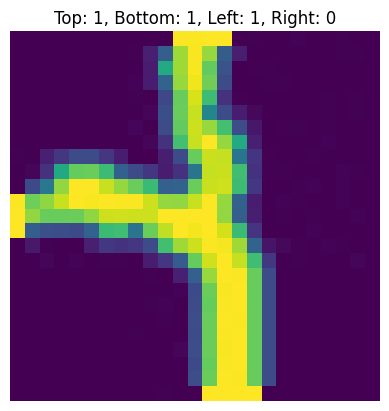

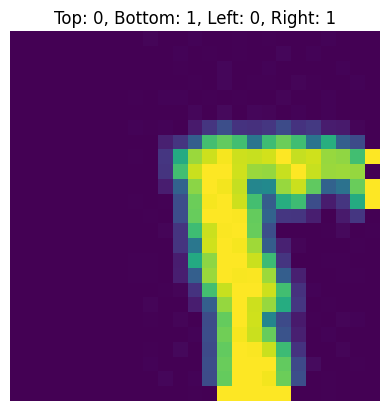

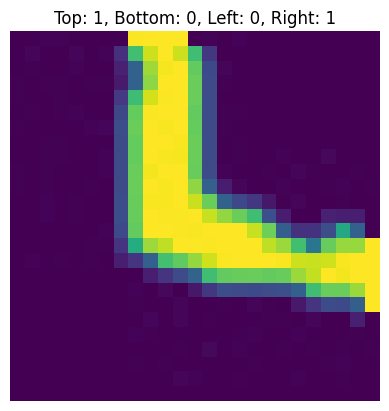

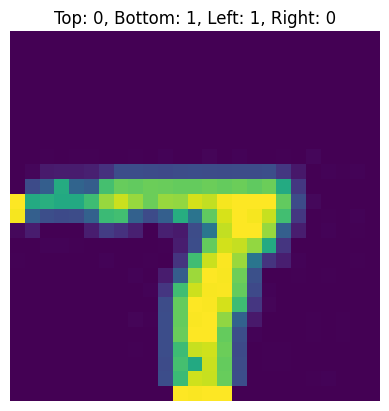

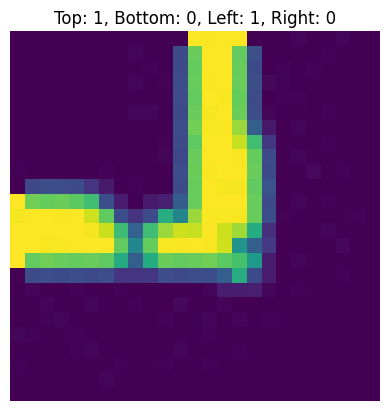

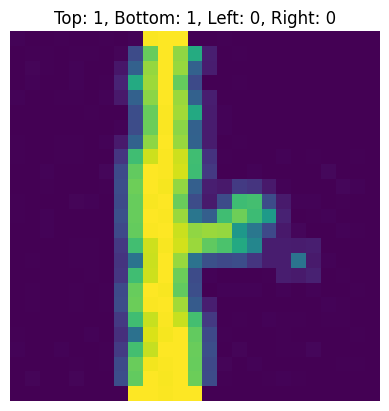

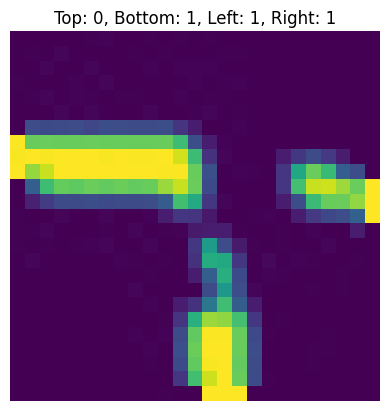

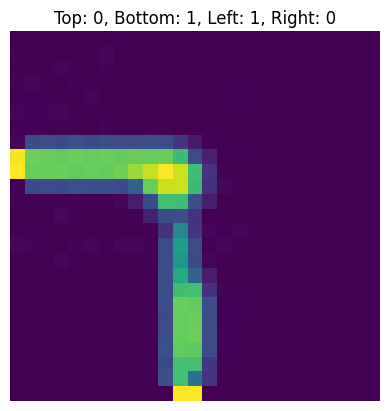

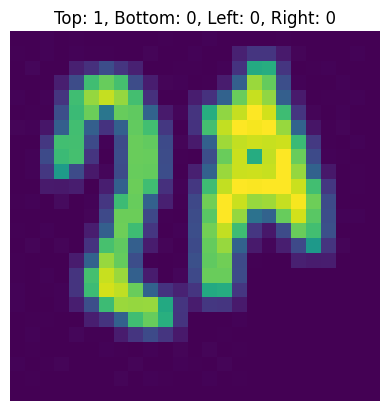

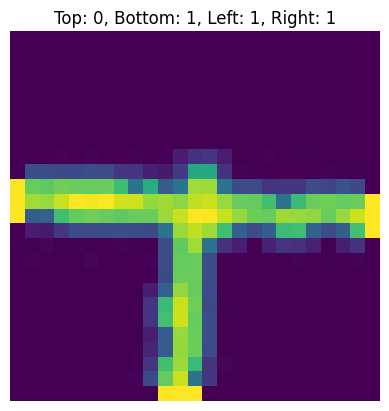

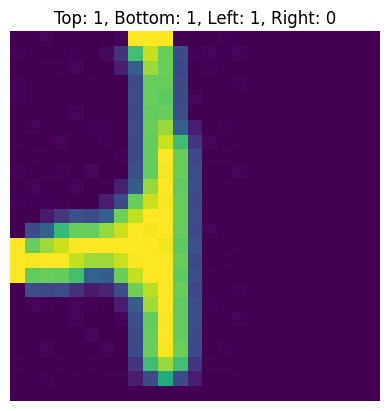

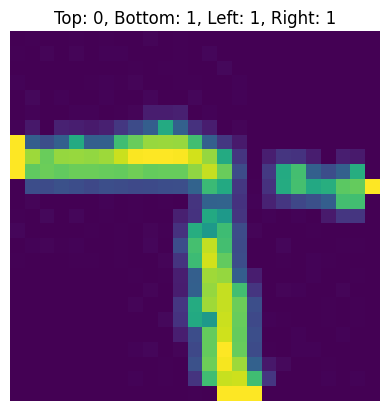

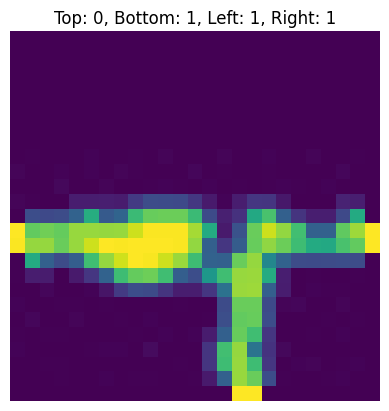

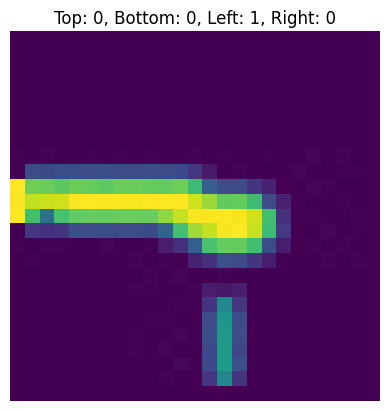

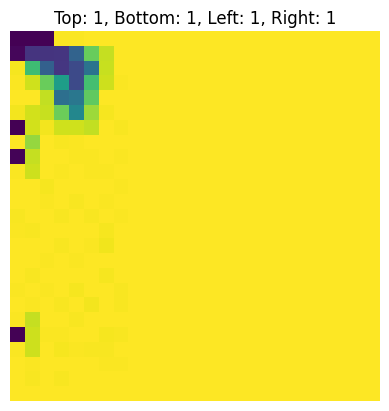

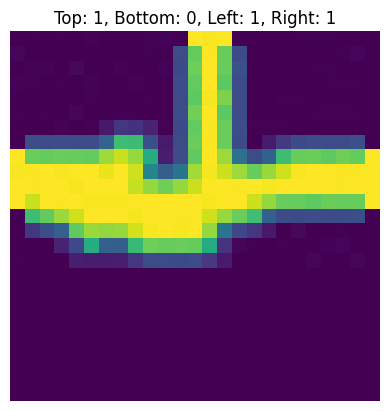

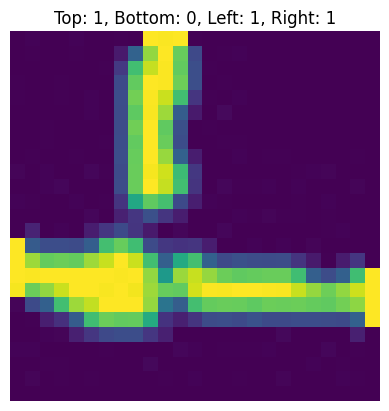

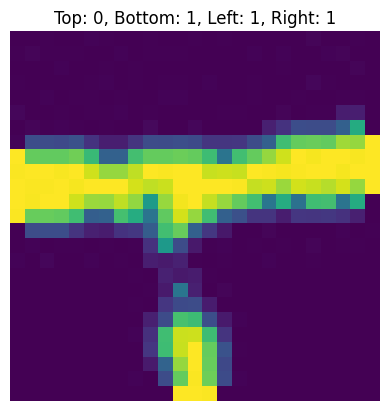

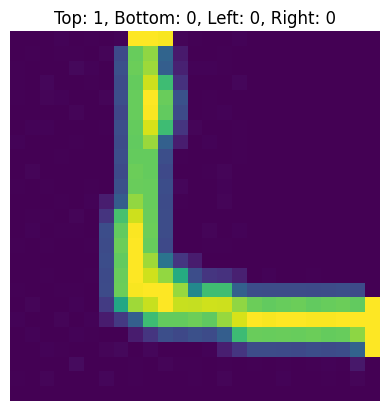

In [59]:
for index, row in df.iterrows():
    img_path = row['Image_Path']
    top_edge = row['Top_Edge']
    bottom_edge = row['Bottom_Edge']
    left_edge = row['Left_Edge']
    right_edge = row['Right_Edge']
    
    # Load the image using PIL
    img = Image.open(img_path)
    
    # Display the image
    plt.imshow(img)
    plt.title(f"Top: {top_edge}, Bottom: {bottom_edge}, Left: {left_edge}, Right: {right_edge}")
    plt.axis('off')  # Hide the axis
    plt.show()
    
    # Ask user if this image should be included
    include = input("Include this image in the dataset? (yes/no): ").lower()
    if include == 'yes':
        selected_images.append(row)

# Convert list to DataFrame
selected_df = pd.DataFrame(selected_images)

# Save to new CSV
selected_df.to_csv('second_selected_image_encodings.csv', index=False)


# check instances

In [70]:
df = pd.read_csv('selected_image_encodings.csv')
df2 = pd.read_csv('second_selected_image_encodings.csv')
df_cat = pd.concat([df,df2], ignore_index=True)


In [63]:
# Group by all label columns and count each unique combination
combination_counts = df_cat.groupby(['Top_Edge', 'Bottom_Edge', 'Left_Edge', 'Right_Edge']).size().reset_index(name='Count')

print(combination_counts)
#dataset is not very equal, so need to gather more data regarding the 0,1,7, 8 and 9 case

   Top_Edge  Bottom_Edge  Left_Edge  Right_Edge  Count
0         0            0          1           1      3
1         0            1          0           1     15
2         0            1          1           0     26
3         0            1          1           1     32
4         1            0          0           1     32
5         1            0          1           0     31
6         1            0          1           1     41
7         1            1          0           1      6
8         1            1          1           0      6
9         1            1          1           1      3


# Copy image to components folder

In [64]:
import pandas as pd
import shutil
import os


In [77]:
base_dir = 'dataset/components'
folders = set(df.apply(lambda row: f"junction_{row['Top_Edge']}_{row['Bottom_Edge']}_{row['Left_Edge']}_{row['Right_Edge']}", axis=1))

# Ensure base directory and all necessary subdirectories exist
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [78]:


for index, row in df.iterrows():
    source_path = 'dataset/circuits/junctions/'+row['Image_Path']
    folder_name = f"junction_{row['Top_Edge']}_{row['Bottom_Edge']}_{row['Left_Edge']}_{row['Right_Edge']}"
    print(source_path)
    # print(folder_name)
    destination_path =os.path.join(base_dir, folder_name, os.path.basename(source_path))
    # print(destination_path)
    # # Copy the file
    shutil.copy2(source_path, destination_path)


dataset/circuits/junctions/C109_D1_P2_jpg.rf.4c683b4eec83898686611d32bf45601c_junction_1.jpg
dataset/circuits/junctions/C10_D1_P3_jpg.rf.7ea7513bdba52649bdd5948aee194204_junction_6.jpg
dataset/circuits/junctions/C10_D1_P3_jpg.rf.7ea7513bdba52649bdd5948aee194204_junction_7.jpg
dataset/circuits/junctions/C10_D1_P4_jpg.rf.faa6a78197d15439416181e4a19ede24_junction_4.jpg
dataset/circuits/junctions/C10_D1_P4_jpg.rf.faa6a78197d15439416181e4a19ede24_junction_6.jpg
dataset/circuits/junctions/C10_D2_P2_jpg.rf.ec830800d81d624d6946cb0b4bd34b3c_junction_9.jpg
dataset/circuits/junctions/C10_D2_P2_jpg.rf.ec830800d81d624d6946cb0b4bd34b3c_junction_10.jpg
dataset/circuits/junctions/C10_D2_P2_jpg.rf.ec830800d81d624d6946cb0b4bd34b3c_junction_11.jpg
dataset/circuits/junctions/C10_D2_P3_jpg.rf.faec6fc245928b6ddc14d0ef5d64f566_junction_4.jpg
dataset/circuits/junctions/C10_D2_P4_jpg.rf.55665fc48c63e5f5e91388125256da92_junction_6.jpg
dataset/circuits/junctions/C10_D2_P4_jpg.rf.55665fc48c63e5f5e91388125256da92_